# Descrição

**Fonte**

O dataset utilizado para análise foi retirado da plataforma [*Kaggle*](https://www.kaggle.com/datasets/natezhang123/social-anxiety-dataset/).

**Introdução**

A ansiedade social é um transtorno amplamente disseminado, caracterizado por medo intenso e persistente de situações sociais, podendo comprometer significativamente a qualidade de vida dos indivíduos. A compreensão desse fenômeno exige a análise conjunta de fatores comportamentais, de estilo de vida e indicadores psicológicos. Nesse contexto, o *Social Anxiety Dataset* reúne mais de 10.000 amostras sintéticas que simulam padrões realistas de indivíduos com diferentes níveis de ansiedade social, oferecendo uma base robusta para estudos em ciência de dados e aprendizado de máquina aplicados à saúde mental.

**Abordagem**

Para analisar os dados, optou-se por atacar o problema como um desafio de classificação, onde a label de uma dada instância é o correspondente nível de ansiedadel, uma variável numérica de 1 a 10.

# Leitura e análise inicial do dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/data.csv')
df.head()

,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10)
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,114,14,4,No,Yes,3,Yes,7,5.0
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,62,23,2,Yes,No,2,No,8,3.0
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,91,28,3,No,No,1,Yes,1,1.0
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,86,17,3,No,No,0,No,1,2.0
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,98,19,4,Yes,Yes,1,No,3,1.0


In [3]:
df.shape

(11000, 19)

In [4]:
# Verifica a quantidade de valores nulos (vazios) em cada coluna
df.isnull().sum()

Age                                  0
Gender                               0
Occupation                           0
Sleep Hours                          0
Physical Activity (hrs/week)         0
Caffeine Intake (mg/day)             0
Alcohol Consumption (drinks/week)    0
Smoking                              0
Family History of Anxiety            0
Stress Level (1-10)                  0
Heart Rate (bpm)                     0
Breathing Rate (breaths/min)         0
Sweating Level (1-5)                 0
Dizziness                            0
Medication                           0
Therapy Sessions (per month)         0
Recent Major Life Event              0
Diet Quality (1-10)                  0
Anxiety Level (1-10)                 0
dtype: int64

Como é de se esperar de um dataset sintético, percebe-se que não há valores nulos.

Abaixo tem-se gráficos mostrando as distribuições das features.

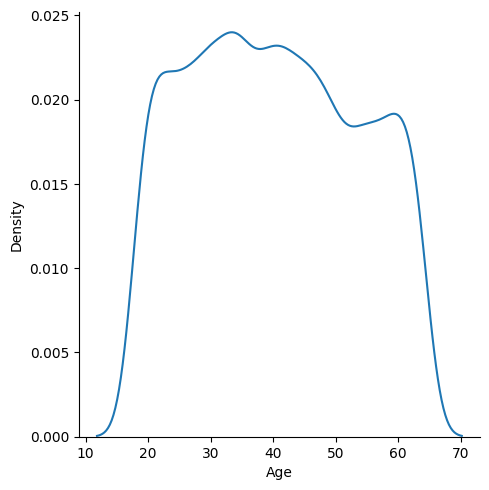

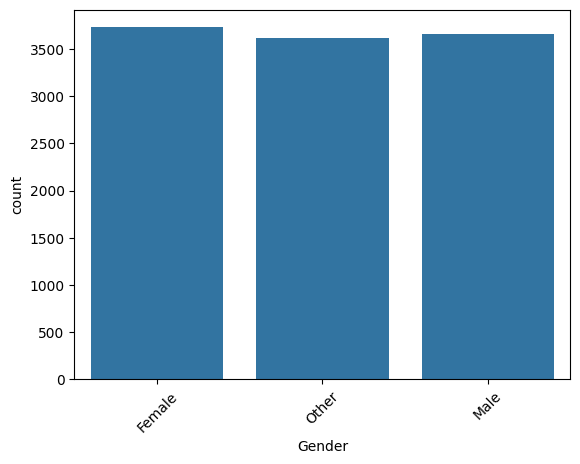

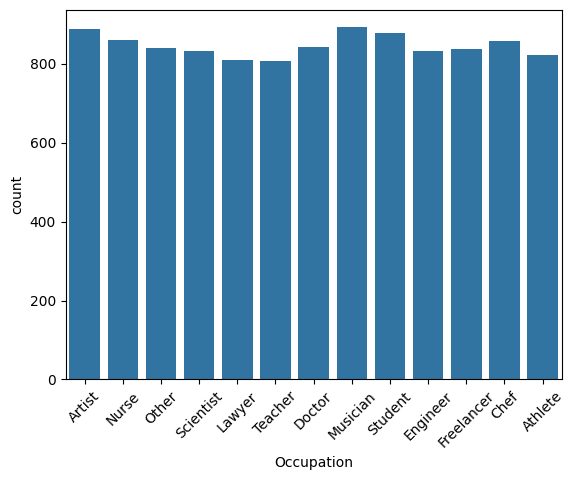

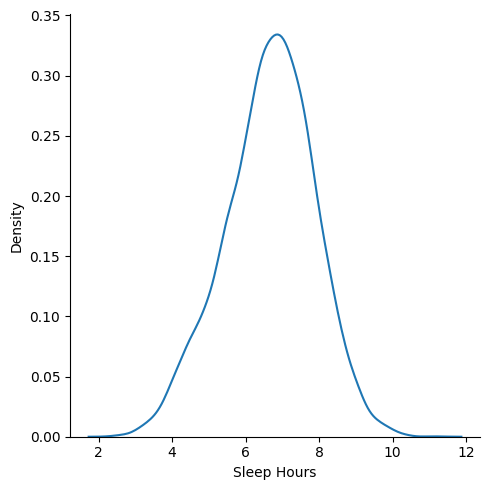

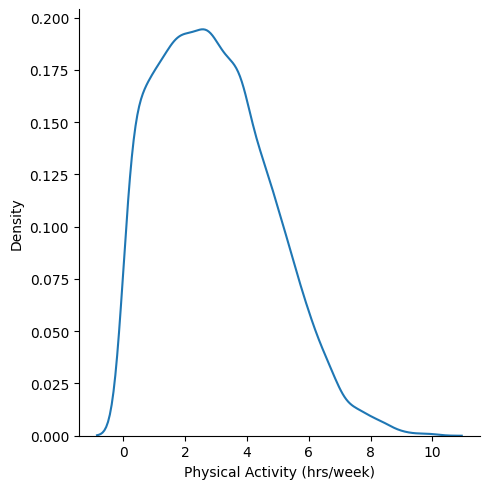

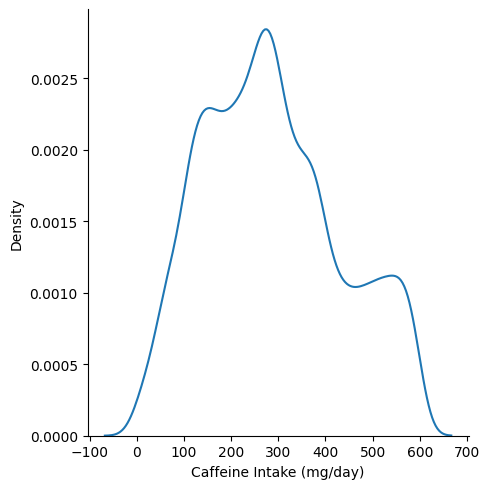

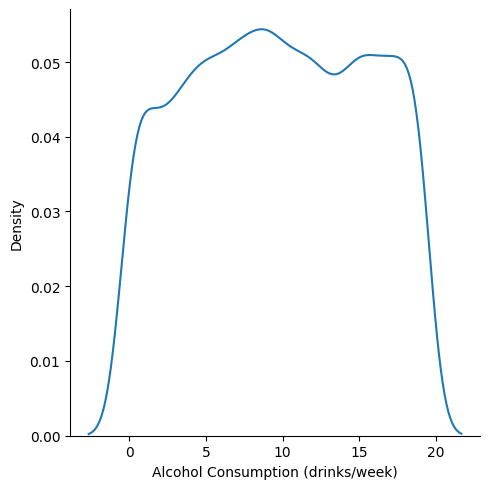

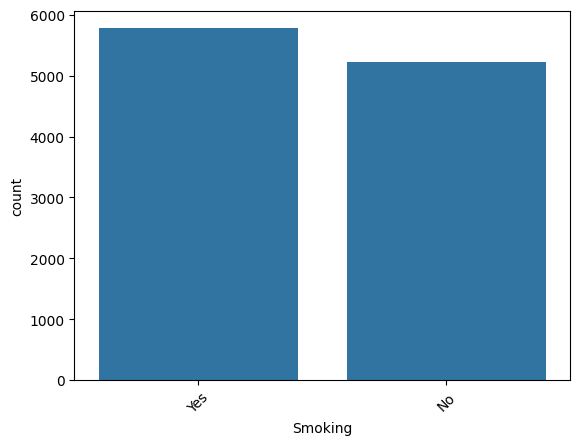

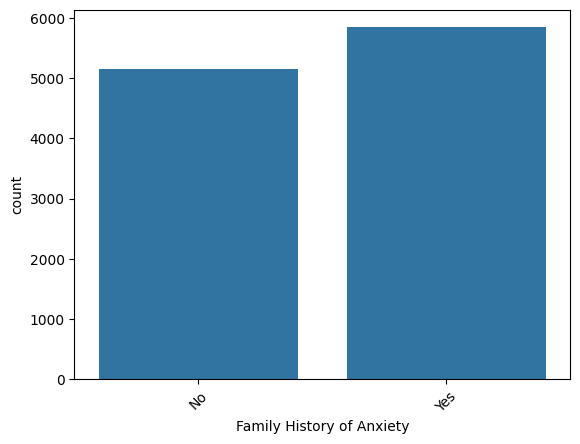

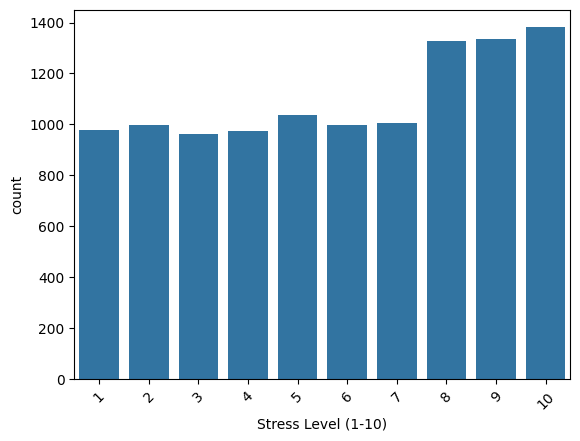

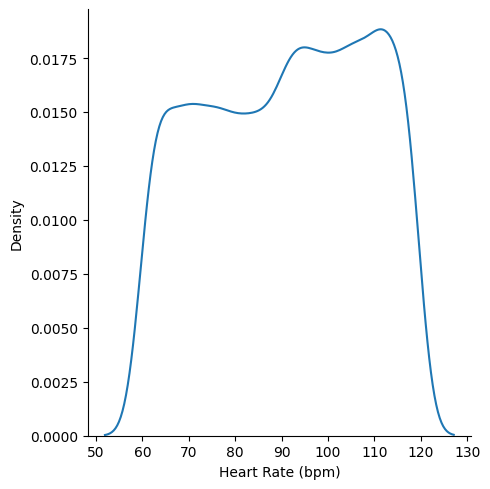

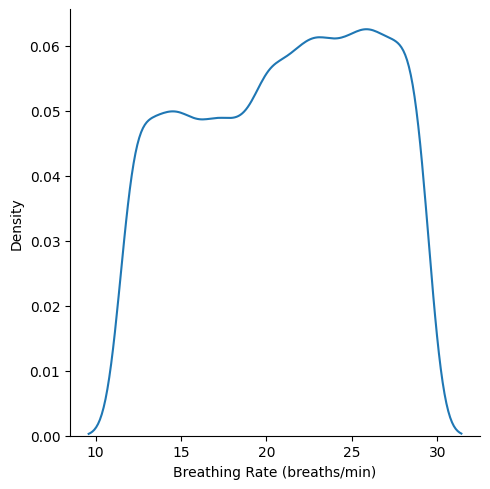

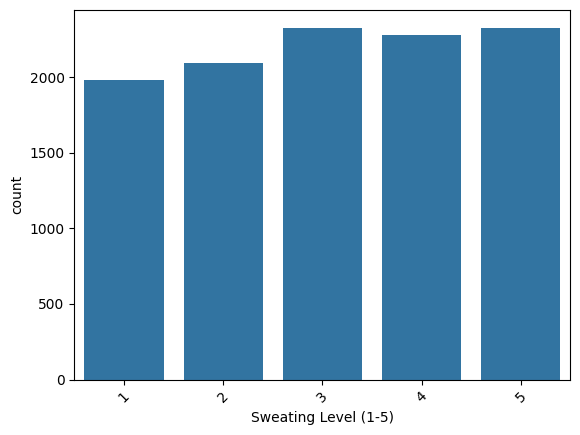

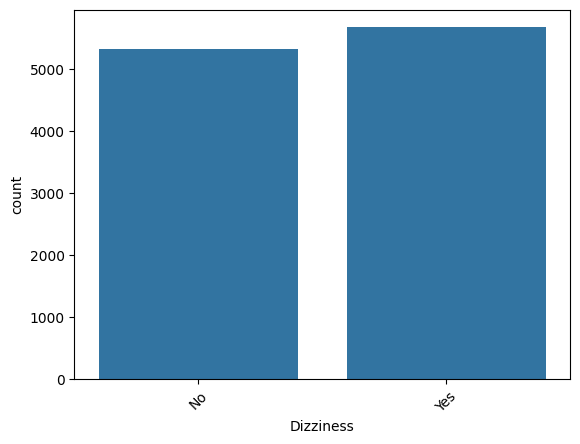

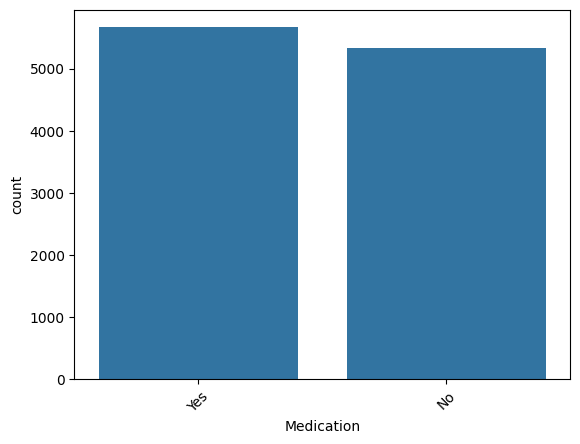

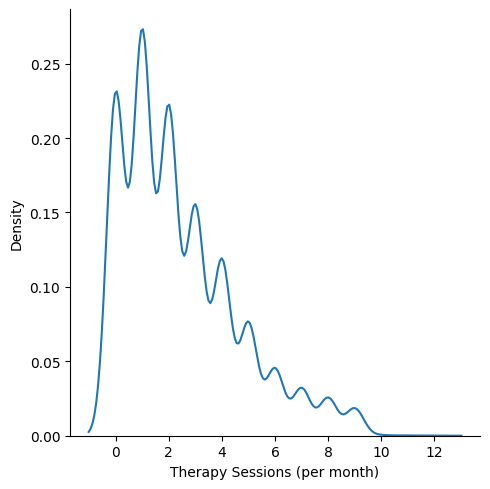

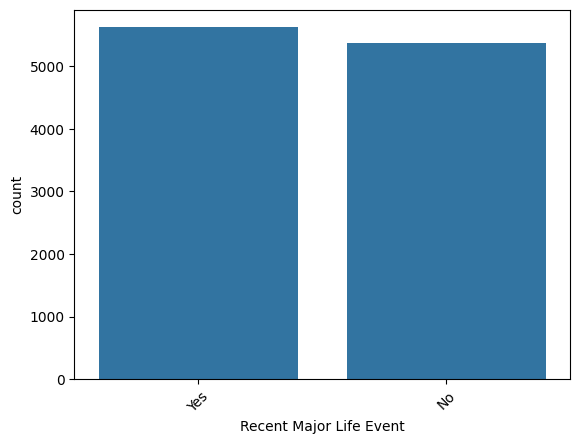

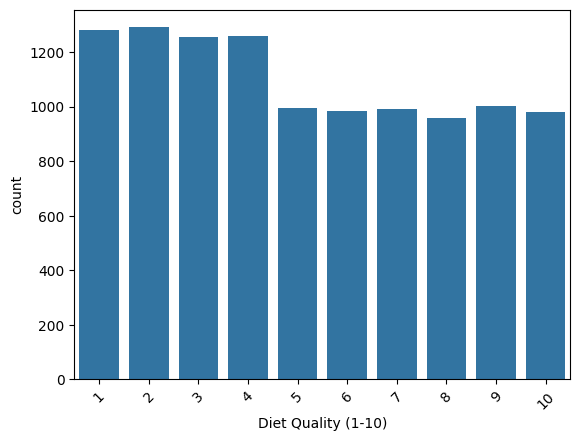

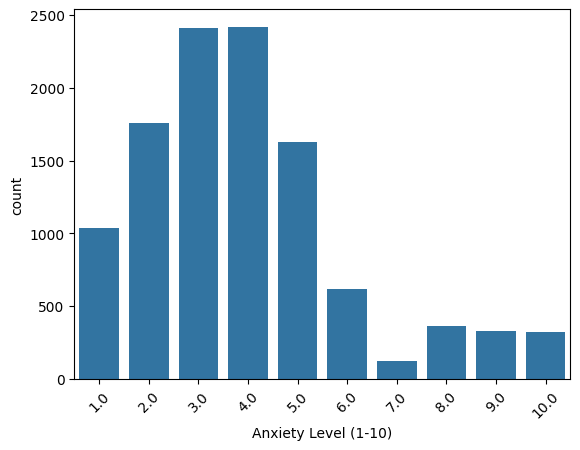

In [5]:
non_numeric_columns = df.select_dtypes(include=['object', 'str']).columns

for col in df.columns:
    if df[col].unique().shape[0] <= 12 or col in non_numeric_columns:
        sns.countplot(data=df, x=col, width=0.8)
        plt.xticks(rotation=45)
        plt.show()
    else:
        sns.displot(data=df, x=col, kind='kde')
        plt.show()

In [6]:
df.describe()

,Age,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Therapy Sessions (per month),Diet Quality (1-10),Anxiety Level (1-10)
count,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000
mean,40.241727,6.650691,2.942136,286.090000,9.701636,5.856364,90.916000,20.957545,3.080636,2.427818,5.181818,3.929364
std,13.236140,1.227509,1.827825,144.813157,5.689713,2.927202,17.325721,5.160107,1.398877,2.183106,2.895243,2.122533
min,18.000000,2.300000,0.000000,0.000000,0.000000,1.000000,60.000000,12.000000,1.000000,0.000000,1.000000,1.000000
25%,29.000000,5.900000,1.500000,172.000000,5.000000,3.000000,76.000000,17.000000,2.000000,1.000000,3.000000,2.000000
50%,40.000000,6.700000,2.800000,273.000000,10.000000,6.000000,92.000000,21.000000,3.000000,2.000000,5.000000,4.000000
75%,51.000000,7.500000,4.200000,382.000000,15.000000,8.000000,106.000000,25.000000,4.000000,4.000000,8.000000,5.000000
max,64.000000,11.300000,10.100000,599.000000,19.000000,10.000000,119.000000,29.000000,5.000000,12.000000,10.000000,10.000000


É interessante notar que o nível de ansiedade não é balanceado: níveis no intervalo $[6, 10]$ representam apenas 25% do dataset.

# Criando labels

In [7]:
import pandas as pd
df = pd.read_csv('data/data.csv')

Para auxiliar as análises decidiu-se criar 4 níveis de labels:
1. **Pouco ansioso (0), muito ansioso (1)** -> `data_level_1.csv`
   1. Pouco ansioso = níveis 1 e 2
   2. Muito ansioso = níveis 9 e 10
2. **Pouco/médio ansioso (0), médio/muito ansioso (1)** -> `data_level_2.csv`
   1. Pouco/médio ansioso = níveis menores ou iguais a 5
   2. Médio/muito ansioso = níveis maiores que 5
3. **Pouco ansioso (0), ansiedade moderada (1), muito ansioso (2)** -> `data_level_3.csv`
   1. Pouco = níveis 1 e 2
   2. Moderada = níveis 4 a 6
   3. Muito  = níveis 9 e 10
4. **Categorias originais** -> `data_level_4.csv`

In [8]:
df_level_1 = df.copy()
df_level_1.rename(columns={'Anxiety Level (1-10)': 'original_label'}, inplace=True)
df_level_1 = df_level_1.loc[(df_level_1['original_label'] <= 2) | (df_level_1['original_label'] >= 9)]
df_level_1['label'] = df_level_1['original_label'].apply(lambda x: 0 if x <= 2 else 1)
df_level_1.to_csv('data/data_level_1.csv', index=False)
df_level_1.shape

(3446, 20)

In [9]:
df_level_2 = df.copy()
df_level_2.rename(columns={'Anxiety Level (1-10)': 'original_label'}, inplace=True)
df_level_2['label'] = df_level_2['original_label'].apply(lambda x: 0 if x <= 5 else 1)
df_level_2.to_csv('data/data_level_2.csv', index=False)
df_level_2.shape

(11000, 20)

In [10]:
df_level_3 = df.copy()
df_level_3.rename(columns={'Anxiety Level (1-10)': 'original_label'}, inplace=True)

def map_anxiety_level(x):
    if x <= 2:
        return 0
    elif x >= 4 and x <= 6:
        return 1
    elif x >= 9:
        return 2

df_level_3['label'] = df_level_3['original_label'].apply(map_anxiety_level)
df_level_3 = df_level_3[df_level_3['label'].notnull()]
df_level_3.to_csv('data/data_level_3.csv', index=False)
df_level_3.shape

(8107, 20)

In [11]:
df_level_4 = df.copy()
df_level_4.rename(columns={'Anxiety Level (1-10)': 'label'}, inplace=True)
df_level_4.to_csv('data/data_level_4.csv', index=False)
df_level_4.shape

(11000, 19)

# Informação mútua & Gráficos de distribuição

Para fazer uma análise da importância das features, optou-se por utilizar o dataset cujas labels identificam extremos: `data_level_1.csv`, onde a label 1 corresponde aos níveis 9 e 10 de ansiedade e a label 0, aos níveis 1 e 2.

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

In [13]:
df = pd.read_csv('data/data_level_1.csv').drop(columns=['original_label'])

In [14]:
# Colunas cujos valores não possuem um range/valores especificado ou que possuem muitos valores únicos.
# Os valores dessas colunas serão tratados como se fossem contínuos (alguns realmente são).
not_specified_range_columns = [
    'Age',
    'Sleep Hours',
    'Physical Activity (hrs/week)',
    'Caffeine Intake (mg/day)',
    'Alcohol Consumption (drinks/week)',
    'Heart Rate (bpm)',
    'Breathing Rate (breaths/min)'
]

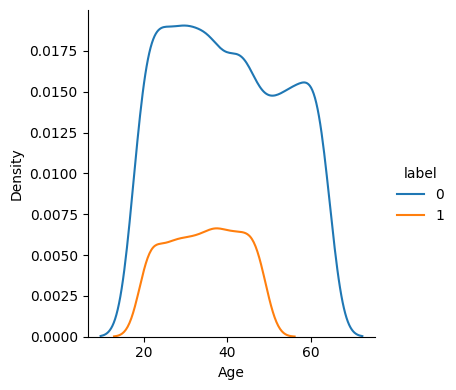

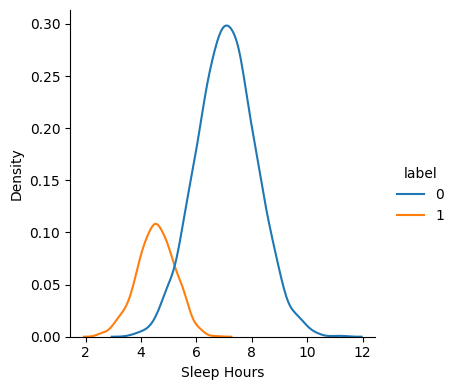

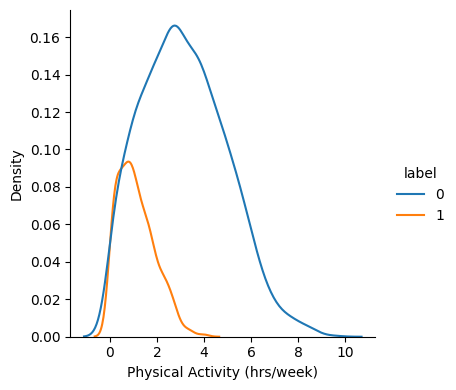

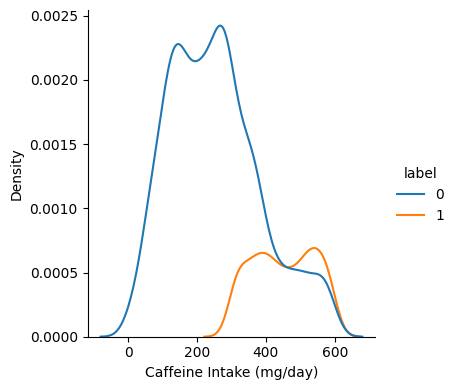

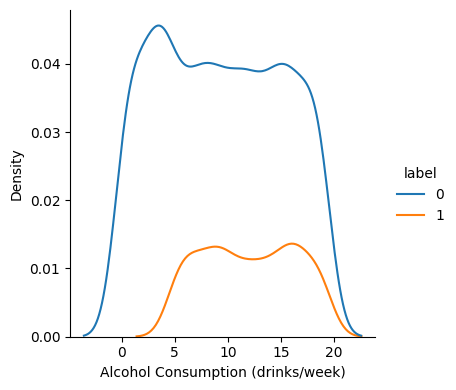

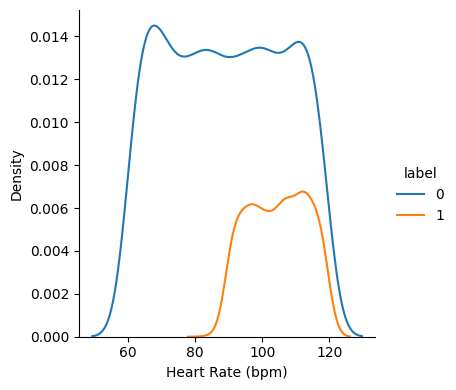

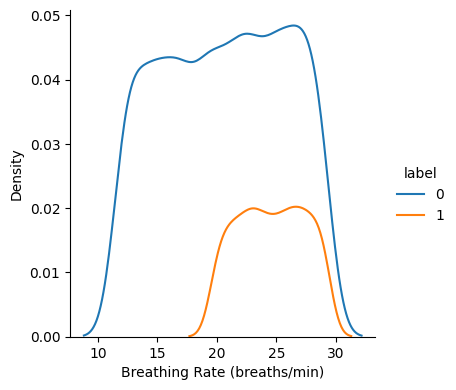

In [15]:
for feature in not_specified_range_columns:
  # sns.relplot(df, y = feature, x = list(range(len(df))), hue = 'label');
  sns.displot(df, x = feature, hue = 'label', kind = 'kde', height=4);

Os gráficos acima demonstram uma relação evidente entre as features e as labels.

A maioria esmagadora dos casos de alta ansiedade se encontra em instâncias com:
1. Idade entre 20 e 50 anos
2. Duração de sono menor que 6 horas
3. 2 ou menos horas de atividade física por semana
4. Consumo de cafeína por dia superior a 300 mg
5. Consumo de álcool superior a 5 drinks por semana
6. Frequência cardíaca superior a 90 bpm
7. Frequência respiratória superior a 20 respirações/min

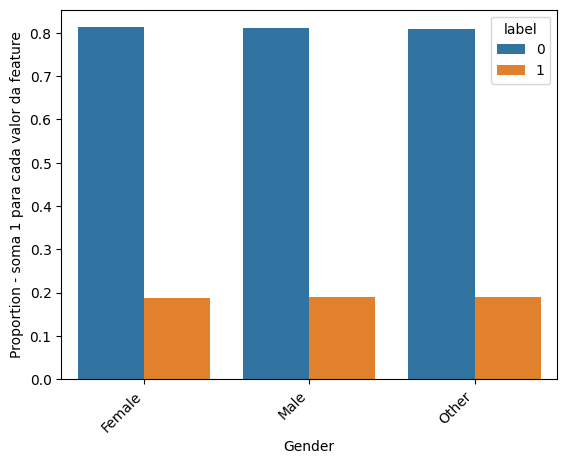

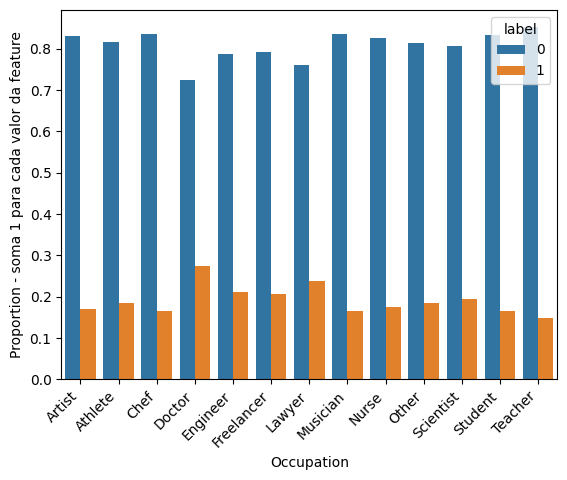

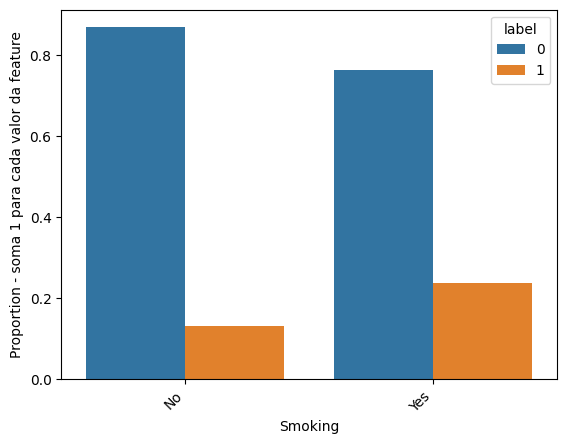

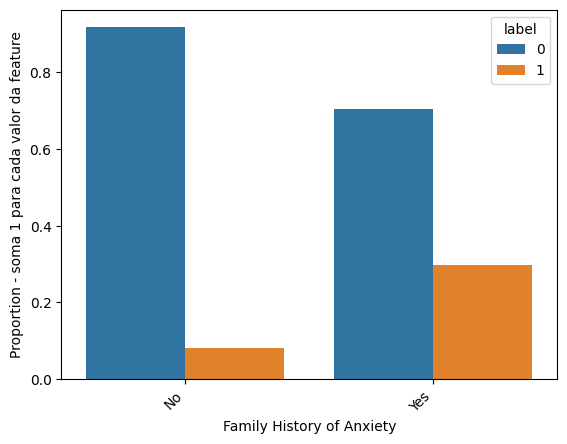

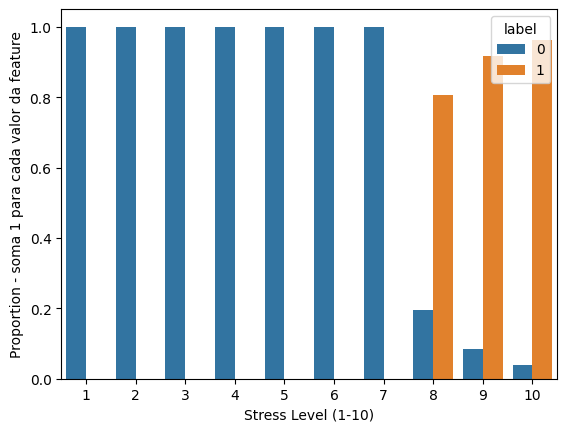

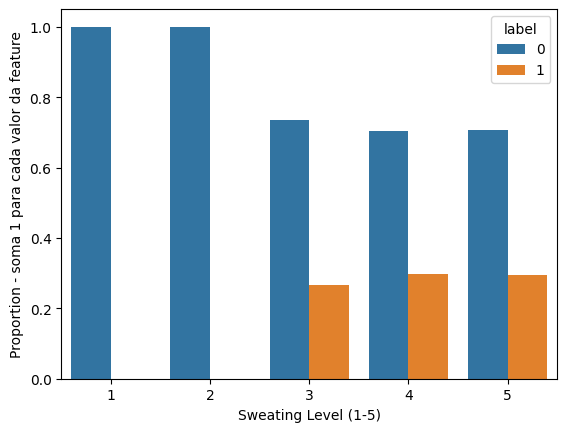

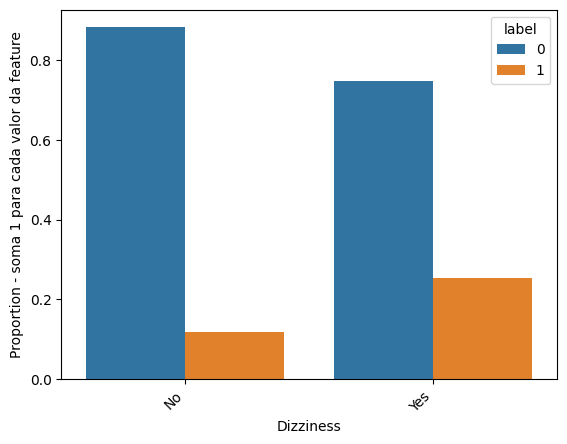

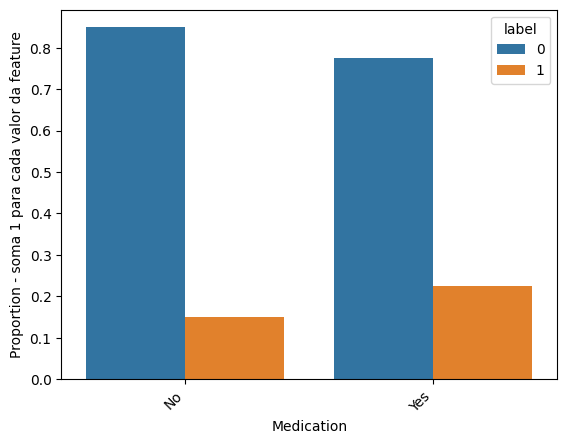

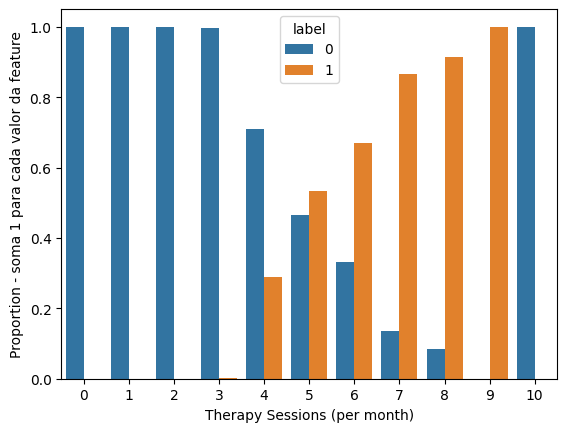

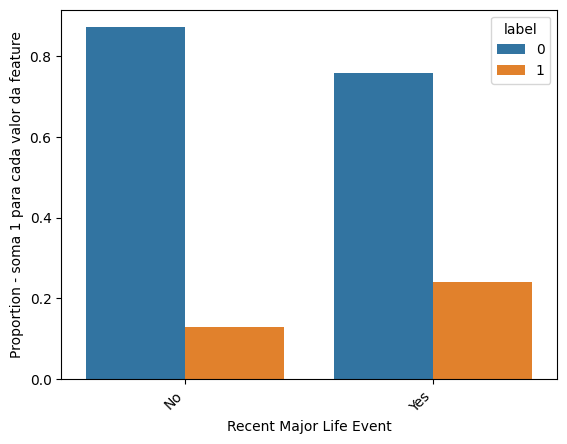

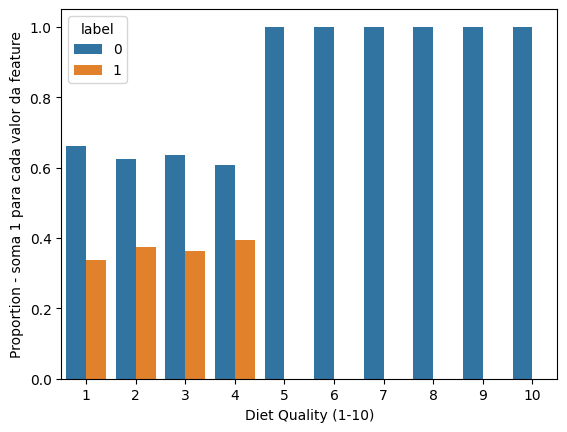

In [16]:
for col in df.columns:
    if col not in not_specified_range_columns + ['label']:
        counts = (
            df
            .groupby([col, 'label'])
            .size()
            .reset_index(name='count')
        )

        counts['prob'] = (
            counts['count']
            / counts.groupby(col)['count'].transform('sum')
        )

        counts.groupby(col)['prob'].sum()

        sns.barplot(
            data=counts,
            x=col,
            y='prob',
            hue='label'
        )
        
        if df[col].dtype in ['object', 'str']:
            plt.xticks(rotation=45, ha='right')
        plt.ylabel('Proportion - soma 1 para cada valor da feature')
        plt.show()

A plotagem acima mostra algumas features com baixíssima relevância (ou seja, as proporções de ansiedade/não ansiedade para valores diferentes da feature são praticamente idênticas), como: gênero, medicação e profissão/ocupação.

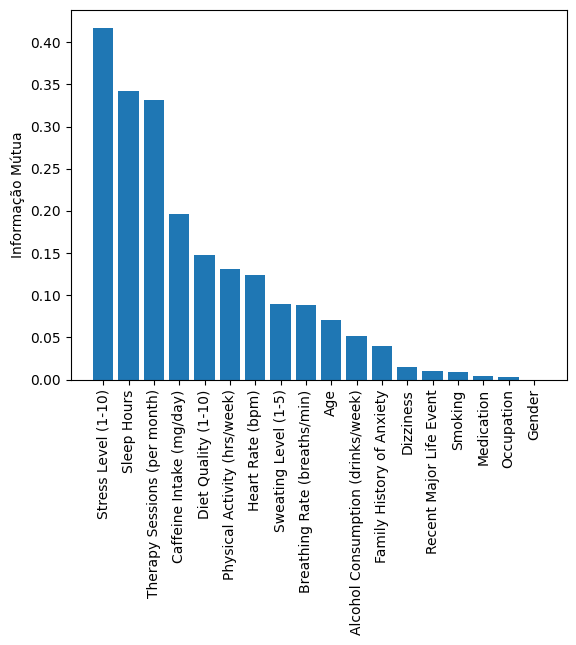

In [17]:
# Faz o encoding das colunas categóricas para o cálculo da informação mútua

non_numeric_columns = df.select_dtypes(include=['object', 'str']).columns
encoder = OrdinalEncoder()
df_encoded = df.copy()
df_encoded[non_numeric_columns] = encoder.fit_transform(df[non_numeric_columns])

X = np.array(df_encoded.drop('label', axis=1))
y = np.array(df_encoded['label'])

discrete_mask = [] # Máscara para indicar quais colunas são discretas
for col in df.drop('label', axis=1).columns:
    discrete_mask.append(col not in not_specified_range_columns)

mi = mutual_info_classif(X, y, discrete_features=discrete_mask)
order = np.argsort(mi)[::-1]

plt.bar(df_encoded.drop('label', axis=1).columns[order], mi[order])
plt.ylabel('Informação Mútua')
plt.xticks(rotation=90);

O gráfico de informação mútua acima reforça as análises anteriores.

# Encoding das features categóricas

Utilizou-se *one-hot encoding* para transformar features categóricas nominais em valores numéricos.

Utilizou-se *drop_first* para evitar redundância entre as novas features criadas: 

$$
is\_A + is\_B + is\_C = 1
$$
$$
is\_A = 1 - (is\_B + is\_C)
$$

In [18]:
df_level_1 = pd.read_csv('data/data_level_1.csv')
df_level_2 = pd.read_csv('data/data_level_2.csv')
df_level_3 = pd.read_csv('data/data_level_3.csv')
df_level_4 = pd.read_csv('data/data_level_4.csv')

In [19]:
categorical_columns = [
    'Smoking',
    'Family History of Anxiety',
    'Dizziness',
    'Medication',
    'Recent Major Life Event',
    'Gender',
    'Occupation'
]

In [20]:
print("Número de colunas antes do encoding:", df_level_1.shape[1])

df_level_1 = pd.get_dummies(df_level_1, columns=categorical_columns, drop_first=True, dtype=int)
df_level_2 = pd.get_dummies(df_level_2, columns=categorical_columns, drop_first=True, dtype=int)
df_level_3 = pd.get_dummies(df_level_3, columns=categorical_columns, drop_first=True, dtype=int)
df_level_4 = pd.get_dummies(df_level_4, columns=categorical_columns, drop_first=True, dtype=int)

assert df_level_1.shape[1] == df_level_2.shape[1] == df_level_3.shape[1] == df_level_4.shape[1] + 1, "DataFrames have different number of columns"
print("Número de colunas após o encoding:", df_level_1.shape[1])

Número de colunas antes do encoding: 20
Número de colunas após o encoding: 32


In [21]:
df_level_1.head()

,Age,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Therapy Sessions (per month),...,Occupation_Doctor,Occupation_Engineer,Occupation_Freelancer,Occupation_Lawyer,Occupation_Musician,Occupation_Nurse,Occupation_Other,Occupation_Scientist,Occupation_Student,Occupation_Teacher
0,64,5.0,3.7,117,4,1,91,28,3,1,...,0,0,0,0,0,0,1,0,0,0
1,20,5.8,2.8,360,6,4,86,17,3,0,...,0,0,0,0,0,0,0,1,0,0
2,49,8.2,2.3,247,4,1,98,19,4,1,...,0,0,0,0,0,0,1,0,0,0
3,30,8.0,5.4,499,4,3,67,22,3,1,...,1,0,0,0,0,0,0,0,0,0
4,38,6.9,7.5,77,14,2,105,17,1,0,...,0,0,0,0,1,0,0,0,0,0


In [22]:
df_level_1.columns

Index(['Age', 'Sleep Hours', 'Physical Activity (hrs/week)',
       'Caffeine Intake (mg/day)', 'Alcohol Consumption (drinks/week)',
       'Stress Level (1-10)', 'Heart Rate (bpm)',
       'Breathing Rate (breaths/min)', 'Sweating Level (1-5)',
       'Therapy Sessions (per month)', 'Diet Quality (1-10)', 'original_label',
       'label', 'Smoking_Yes', 'Family History of Anxiety_Yes',
       'Dizziness_Yes', 'Medication_Yes', 'Recent Major Life Event_Yes',
       'Gender_Male', 'Gender_Other', 'Occupation_Athlete', 'Occupation_Chef',
       'Occupation_Doctor', 'Occupation_Engineer', 'Occupation_Freelancer',
       'Occupation_Lawyer', 'Occupation_Musician', 'Occupation_Nurse',
       'Occupation_Other', 'Occupation_Scientist', 'Occupation_Student',
       'Occupation_Teacher'],
      dtype='str')

In [23]:
df_level_1.to_csv('data/data_level_1.csv', index=False)
df_level_2.to_csv('data/data_level_2.csv', index=False)
df_level_3.to_csv('data/data_level_3.csv', index=False)
df_level_4.to_csv('data/data_level_4.csv', index=False)

# Divisão treino/teste & Redimensionamento

Optou-se por separar **25%** do conjunto de dados para teste.

Além disso, como as features possuem diferentes ranges (o que afeta algoritmos baseados em distâncias, como o *KNN*), optou-se por redimensionar utilizando o [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#minmaxscaler), de modo que todas as features terão range $[0,1]$ e valores nulos permanecerão nulos (útil para features binárias).

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os

In [25]:
df_level_1 = pd.read_csv('data/data_level_1.csv')
df_level_2 = pd.read_csv('data/data_level_2.csv')
df_level_3 = pd.read_csv('data/data_level_3.csv')
df_level_4 = pd.read_csv('data/data_level_4.csv')

In [26]:
X_1 = df_level_1.drop(['label', 'original_label'], axis=1); y_1 = df_level_1['label']
X_2 = df_level_2.drop(['label', 'original_label'], axis=1); y_2 = df_level_2['label']
X_3 = df_level_3.drop(['label', 'original_label'], axis=1); y_3 = df_level_3['label']
X_4 = df_level_4.drop(['label'], axis=1); y_4 = df_level_4['label']

In [27]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.25, random_state=42)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.25, random_state=42)
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=0.25, random_state=42)
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4, y_4, test_size=0.25, random_state=42)

In [28]:
scaler_1 = MinMaxScaler()
X_1_train_scaled = scaler_1.fit_transform(X_1_train)
X_1_test_scaled = scaler_1.transform(X_1_test)

scaler_2 = MinMaxScaler()
X_2_train_scaled = scaler_2.fit_transform(X_2_train)
X_2_test_scaled = scaler_2.transform(X_2_test)

scaler_3 = MinMaxScaler()
X_3_train_scaled = scaler_3.fit_transform(X_3_train)
X_3_test_scaled = scaler_3.transform(X_3_test)

scaler_4 = MinMaxScaler()
X_4_train_scaled = scaler_4.fit_transform(X_4_train)
X_4_test_scaled = scaler_4.transform(X_4_test)

In [29]:
os.makedirs('train_data', exist_ok=True)
os.makedirs('test_data', exist_ok=True)

In [30]:
# Salvando dados de treino

df_1 = pd.DataFrame(X_1_train_scaled, columns=X_1.columns)
df_1['label'] = y_1_train.reset_index(drop=True)
df_1['original_label'] = df_level_1.loc[y_1_train.index, 'original_label'].reset_index(drop=True)
df_1.to_csv('train_data/train_level_1.csv', index=False)

df_2 = pd.DataFrame(X_2_train_scaled, columns=X_2.columns)
df_2['label'] = y_2_train.reset_index(drop=True)
df_2['original_label'] = df_level_2.loc[y_2_train.index, 'original_label'].reset_index(drop=True)
df_2.to_csv('train_data/train_level_2.csv', index=False)

df_3 = pd.DataFrame(X_3_train_scaled, columns=X_3.columns)
df_3['label'] = y_3_train.reset_index(drop=True)
df_3['original_label'] = df_level_3.loc[y_3_train.index, 'original_label'].reset_index(drop=True)
df_3.to_csv('train_data/train_level_3.csv', index=False)

df_4 = pd.DataFrame(X_4_train_scaled, columns=X_4.columns)
df_4['label'] = y_4_train.reset_index(drop=True)
df_4.to_csv('train_data/train_level_4.csv', index=False)

In [31]:
# Salvando dados de teste

df_1_test = pd.DataFrame(X_1_test_scaled, columns=X_1.columns)
df_1_test['label'] = y_1_test.reset_index(drop=True)
df_1_test['original_label'] = df_level_1.loc[y_1_test.index, 'original_label'].reset_index(drop=True)
df_1_test.to_csv('test_data/test_level_1.csv', index=False)

df_2_test = pd.DataFrame(X_2_test_scaled, columns=X_2.columns)
df_2_test['label'] = y_2_test.reset_index(drop=True)
df_2_test['original_label'] = df_level_2.loc[y_2_test.index, 'original_label'].reset_index(drop=True)
df_2_test.to_csv('test_data/test_level_2.csv', index=False)

df_3_test = pd.DataFrame(X_3_test_scaled, columns=X_3.columns)
df_3_test['label'] = y_3_test.reset_index(drop=True)
df_3_test['original_label'] = df_level_3.loc[y_3_test.index, 'original_label'].reset_index(drop=True)
df_3_test.to_csv('test_data/test_level_3.csv', index=False)

df_4_test = pd.DataFrame(X_4_test_scaled, columns=X_4.columns)
df_4_test['label'] = y_4_test.reset_index(drop=True)
df_4_test.to_csv('test_data/test_level_4.csv', index=False)

# Diminuindo dimensão para vizualização

In [32]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
import pandas as pd
import seaborn as sns

In [33]:
train_df_level_1 = pd.read_csv('train_data/train_level_1.csv')
X = train_df_level_1.drop(['label', 'original_label'], axis=1)
y = train_df_level_1['label']

## PCA

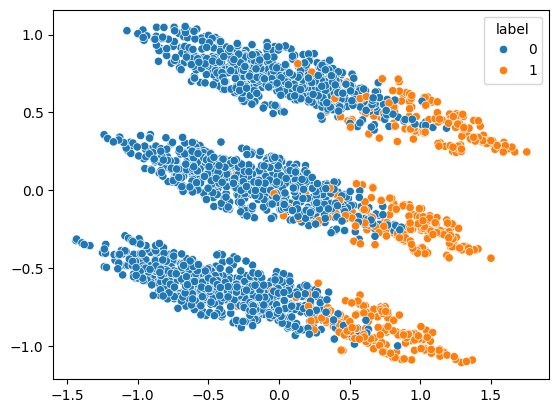

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=y);

## t-SNE

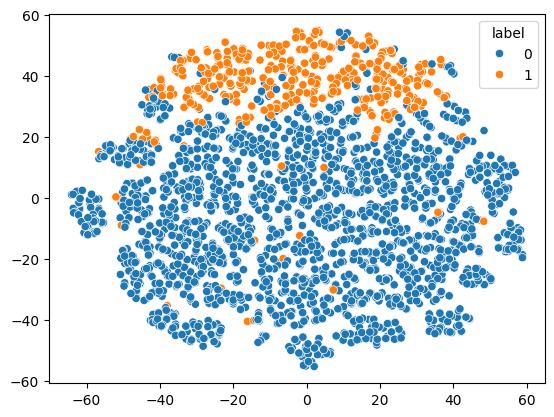

In [ ]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X)
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=y);

## MDS

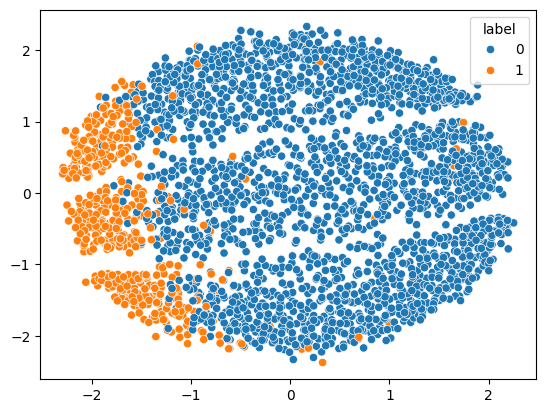

In [ ]:
mds = MDS(n_components=2, n_init=2, init='random')
mds_result = mds.fit_transform(X)
sns.scatterplot(x=mds_result[:, 0], y=mds_result[:, 1], hue=y);

## Análise

Os gráficos evidenciam que, apesar de grupos distintos não gerarem clusters separados e bem definidos, os casos de alta ansiedade (label 1) ficam sempre próximos uns dos outros, além de não haver alta sobreposição entre instâncias de grupos distintos.

# KNN ($k$-*Nearest Neighbors*)

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns

## Nível 1

Nessa seção será avaliado o desempenho do KNN para as categorias no nível um (muito ansioso e pouco ansioso).

In [135]:
train_df_level_1 = pd.read_csv('train_data/train_level_1.csv')
X_1_train = train_df_level_1.drop(['label', 'original_label'], axis=1)
y_1_train = train_df_level_1['label']

test_df_level_1 = pd.read_csv('test_data/test_level_1.csv')
X_1_test = test_df_level_1.drop(['label', 'original_label'], axis=1)
y_1_test = test_df_level_1['label']

In [43]:
params = {'n_neighbors': list(range(1, 42, 2))}

In [44]:
clf = GridSearchCV(KNeighborsClassifier(), params, cv=5)
clf.fit(X_1_train, y_1_train)
print(f"Melhor valor de n_neighbors: {clf.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 37


In [45]:
y_pred = clf.predict(X_1_test)
print(classification_report(y_1_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       701
           1       0.99      0.98      0.98       161

    accuracy                           0.99       862
   macro avg       0.99      0.99      0.99       862
weighted avg       0.99      0.99      0.99       862



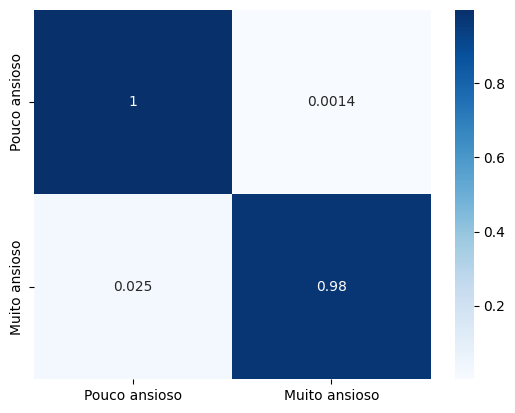

In [46]:
sns.heatmap(confusion_matrix(y_1_test, y_pred, normalize='true'), annot=True, cmap='Blues', xticklabels=['Pouco ansioso', 'Muito ansioso'], yticklabels=['Pouco ansioso', 'Muito ansioso']);

É possível perceber que o desempenho do algoritmo foi excelente, tendo valores de acurácia, precisão e recall próximos de 100%. Esses valores evidenciam que classificar grupos extremos é um problema fácil, bastando ver a label da maioria para as 37 instâncias mais próximas de um dado ponto.

### PCA

A seguir, tem-se uma análise do desempenho do algoritmo reduzindo a dimensão dos dados de 31 para 3 utilizando PCA.

In [47]:
pca = PCA(n_components=3)
X_1_train_2d = pca.fit_transform(X_1_train)
clf.fit(X_1_train_2d, y_1_train)
print(f"Melhor valor de n_neighbors: {clf.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 1


In [48]:
X_1_test_2d = pca.transform(X_1_test)
y_pred_2d = clf.predict(X_1_test_2d)
print(classification_report(y_1_test, y_pred_2d))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       701
           1       0.97      0.96      0.97       161

    accuracy                           0.99       862
   macro avg       0.98      0.98      0.98       862
weighted avg       0.99      0.99      0.99       862



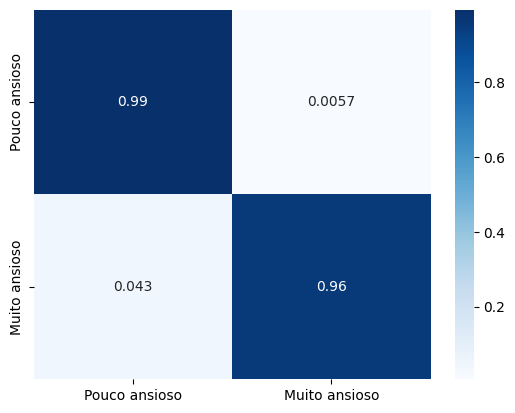

In [49]:
sns.heatmap(confusion_matrix(y_1_test, y_pred_2d, normalize='true'), annot=True, cmap='Blues', xticklabels=['Pouco ansioso', 'Muito ansioso'], yticklabels=['Pouco ansioso', 'Muito ansioso']);

É possível notar que, mesmo com apenas três dimensões, os resultados foram excelentes (muito próximo do obtido utilizando as 31 dimensões).

Obs.: é interessante perceber que o *grid search* achou $k = 1$ como melhor parâmetro (ou seja, para classificar um dado ponto, basta ver a label do ponto mais próximo a esse).

Esses dados reforçam a ideia de que classificar instâncias extremas é realmente algo simples.

### Testando com a remoção de features irrelevantes

A seguir tem-se uma análise do impacto no desempenho do algoritmo ao remover features de baixa relevância.

Obs.: escolheu as últimas 6 features do gráfico de informação mútua.

In [137]:
aux = [
    'Dizziness',
    'Recent Major Life Event',
    'Smoking',
    'Medication',
    'Occupation',
    'Gender'
]

irrelevant_cols = list()
for df_col in train_df_level_1.columns:
    for c in aux:
        if c in df_col:
            irrelevant_cols.append(df_col)

print("Número de colunas antes:", X_1_train.shape[1])
print("Número de colunas após a remoção:", X_1_train.shape[1] - len(irrelevant_cols))

Número de colunas antes: 30
Número de colunas após a remoção: 12


In [51]:
X_1_train_no_irrelevant = train_df_level_1.drop(columns=irrelevant_cols + ['label', 'original_label'])
clf.fit(X_1_train_no_irrelevant, y_1_train)
print(f"Melhor valor de n_neighbors: {clf.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 3


In [52]:
y_pred_no_irrelevant = clf.predict(test_df_level_1.drop(columns=irrelevant_cols + ['label', 'original_label']))
print(classification_report(y_1_test, y_pred_no_irrelevant))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       701
           1       0.99      1.00      0.99       161

    accuracy                           1.00       862
   macro avg       0.99      1.00      1.00       862
weighted avg       1.00      1.00      1.00       862



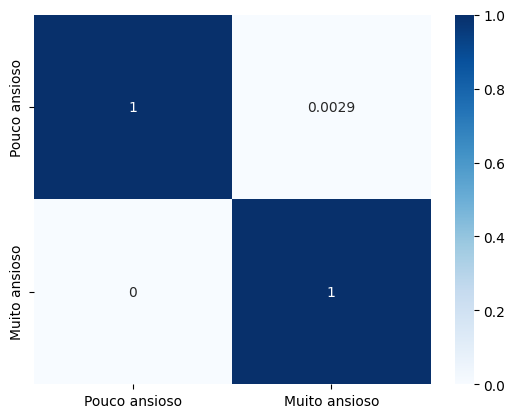

In [53]:
sns.heatmap(confusion_matrix(y_1_test, y_pred_no_irrelevant, normalize='true'), annot=True, cmap='Blues', xticklabels=['Pouco ansioso', 'Muito ansioso'], yticklabels=['Pouco ansioso', 'Muito ansioso']);

É interessante notar que, apesar de não ser usual, ao remover as features de baixa relevância as métricas de desempenho se mostraram superiores (ou seja, além de gerarem um ruído, elas acabaram acrescentando um viés prejudicial a partir dos dados de treino, o que acabou deixando o algoritmo menos generalizável).

## Nível 2

Nessa seção será avaliado o desempenho do KNN para o nível 2 (pouco/médio ansioso vs médio/muito ansioso).

In [54]:
train_df_level_2 = pd.read_csv('train_data/train_level_2.csv')
X_2_train = train_df_level_2.drop(['label', 'original_label'], axis=1)
y_2_train = train_df_level_2['label']

test_df_level_2 = pd.read_csv('test_data/test_level_2.csv')
X_2_test = test_df_level_2.drop(['label', 'original_label'], axis=1)
y_2_test = test_df_level_2['label']

In [55]:
clf2 = GridSearchCV(KNeighborsClassifier(), params, cv=5)
clf2.fit(X_2_train, y_2_train)
print(f"Melhor valor de n_neighbors: {clf2.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 35


In [56]:
print("Resultados no conjunto de treinamento:")
print(classification_report(y_2_train, clf2.predict(X_2_train)))

Resultados no conjunto de treinamento:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      6954
           1       0.97      0.41      0.57      1296

    accuracy                           0.90      8250
   macro avg       0.93      0.70      0.76      8250
weighted avg       0.91      0.90      0.89      8250



In [57]:
y2_pred = clf2.predict(X_2_test)
print("Resultados no conjunto de teste:")
print(classification_report(y_2_test, y2_pred))

Resultados no conjunto de teste:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2293
           1       0.97      0.39      0.56       457

    accuracy                           0.90      2750
   macro avg       0.93      0.69      0.75      2750
weighted avg       0.91      0.90      0.88      2750



Matriz de confusão para o conjunto de teste:


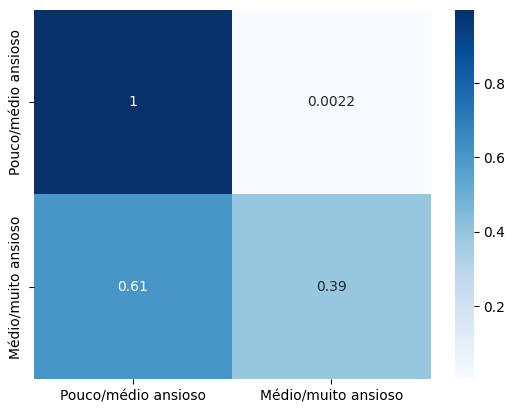

In [58]:
print("Matriz de confusão para o conjunto de teste:")
sns.heatmap(confusion_matrix(y_2_test, y2_pred, normalize='true'), xticklabels=['Pouco/médio ansioso', 'Médio/muito ansioso'], yticklabels=['Pouco/médio ansioso', 'Médio/muito ansioso'], annot=True, cmap='Blues');

A partir das métricas, é notável a dificuldade do modelo em classificar casos de média/alta ansiedade (até mesmo no próprio conjunto de treinamento, onde as métricas não diferem muito das obtidas no conjunto de teste).

Uma forte hipótese para esse comportamento é a subjetividade existente entre níveis de ansiedade próximos, especialmente entre os níveis 4, 5 e 6. Os gráficos abaixo reforçam essa interpretação. O primeiro gráfico indica que a maior concentração de erros do tipo falso negativo (FN) ocorre justamente nos casos de ansiedade nível 6 (correspondem a aproximadamente 60% do total de FNs). Já o segundo gráfico mostra que, entre esses FNs originalmente rotulados como nível 6, mais de 40% apresentam como instância mais próxima exemplos pertencentes aos níveis de ansiedade 4 e 5.

Distribuição dos níveis de ansiedade (1-10) para os casos classificados como "Pouco/médio ansioso" (0) mas que são "Médio/muito ansioso" (1), ou seja, falsos negativos:


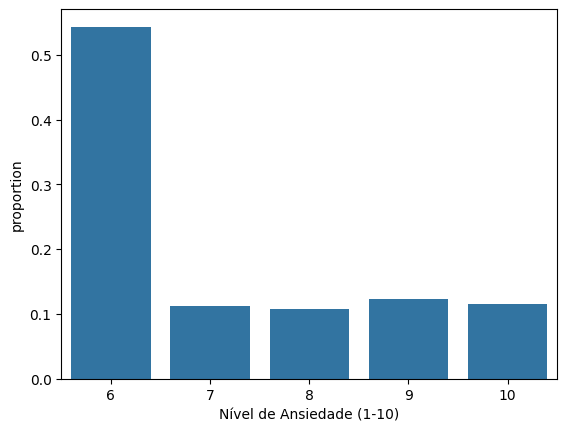

In [59]:
# Lista para armazenar os níveis de ansiedade originais dos casos classificados como falsos negativos (classificados como "Pouco/médio ansioso" mas que são "Médio/muito ansioso")
aux = list()

# Lista para armazenar os níveis de ansiedade dos pontos mais próximos daqueles de nível 6 classificados como falsos negativos (classificados como "Pouco/médio ansioso" mas que são "Médio/muito ansioso")
closest_to_instance_of_fn_of_level_6 = list()
for i, (y_hat, y_true) in enumerate(zip(y2_pred, y_2_test)):
    if y_true == 1 and y_hat == 0:
        original_label = int(test_df_level_2['original_label'].iloc[i])
        aux.append(original_label)
        if original_label == 6:
            # Encontra o ponto mais próximo
            distances = np.linalg.norm(X_2_test - X_2_test.iloc[i], axis=1)
            distances[i] = np.inf  # Ignora a própria instância
            closest_index = np.argmin(distances)
            closest_to_instance_of_fn_of_level_6.append(test_df_level_2['original_label'].iloc[closest_index])

print('Distribuição dos níveis de ansiedade (1-10) para os casos classificados como "Pouco/médio ansioso" (0) mas que são "Médio/muito ansioso" (1), ou seja, falsos negativos:')
sns.countplot(x=aux, stat='proportion');
plt.xlabel('Nível de Ansiedade (1-10)');

Distribuição dos níveis de ansiedade (1-10) dos pontos mais próximos aos falsos negativos que são do nível 6:


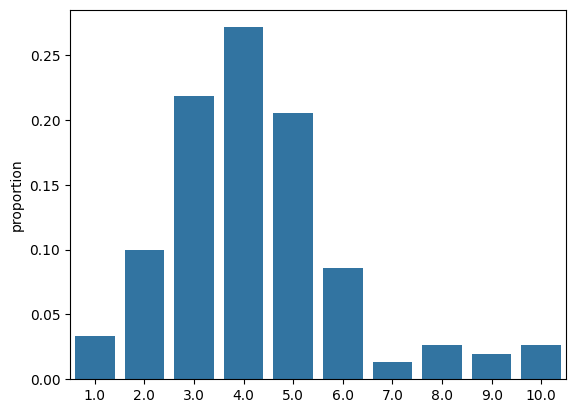

In [60]:
sns.countplot(x=closest_to_instance_of_fn_of_level_6, stat='proportion');
print("Distribuição dos níveis de ansiedade (1-10) dos pontos mais próximos aos falsos negativos que são do nível 6:")

### PCA

In [61]:
pca = PCA(n_components=3)
X_2_train_2d = pca.fit_transform(X_2_train)
clf2.fit(X_2_train_2d, y_2_train)
print(f"Melhor valor de n_neighbors: {clf2.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 5


In [62]:
X_2_test_2d = pca.transform(X_2_test)
y2_pred_2d = clf2.predict(X_2_test_2d)
print(classification_report(y_2_test, y2_pred_2d))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2293
           1       0.89      0.54      0.67       457

    accuracy                           0.91      2750
   macro avg       0.90      0.76      0.81      2750
weighted avg       0.91      0.91      0.90      2750



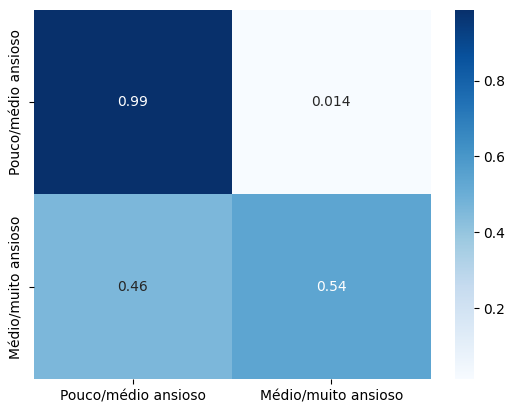

In [63]:
sns.heatmap(confusion_matrix(y_2_test, y2_pred_2d, normalize='true'), xticklabels=['Pouco/médio ansioso', 'Médio/muito ansioso'], yticklabels=['Pouco/médio ansioso', 'Médio/muito ansioso'], annot=True, cmap='Blues');

Supreendentemente a redução de dimensionalidade acabou resultando em uma melhora na média das medidas de desempenho (o que não deve ser levado em conta isoladamente, dado que o custo da precisão e recall podem não ser simétricos para o domínio).

### Testando com a remoção de features irrelevantes

In [64]:
X_2_train_no_irrelevant = train_df_level_2.drop(columns=irrelevant_cols + ['label', 'original_label'])
clf2.fit(X_2_train_no_irrelevant, y_2_train)
print(f"Melhor valor de n_neighbors: {clf2.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 33


              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2293
           1       0.95      0.60      0.74       457

    accuracy                           0.93      2750
   macro avg       0.94      0.80      0.85      2750
weighted avg       0.93      0.93      0.92      2750



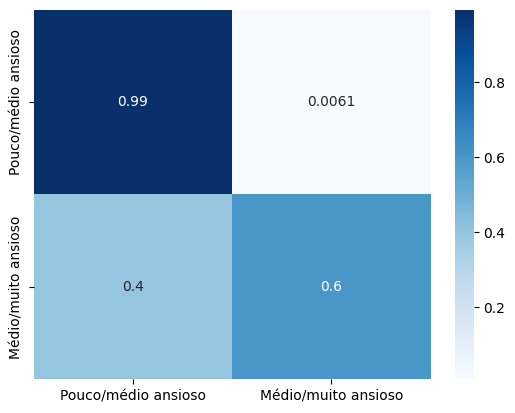

In [65]:
y2_pred_no_irrelevant = clf2.predict(test_df_level_2.drop(columns=irrelevant_cols + ['label', 'original_label']))
print(classification_report(y_2_test, y2_pred_no_irrelevant))
sns.heatmap(confusion_matrix(y_2_test, y2_pred_no_irrelevant, normalize='true'), xticklabels=['Pouco/médio ansioso', 'Médio/muito ansioso'], yticklabels=['Pouco/médio ansioso', 'Médio/muito ansioso'], annot=True, cmap='Blues');

Remover features de baixa relevância melhorou ainda mais a performance (quando comparada com a redução de dimensionalidade). Isso reforça a hipótese sugerida na seção anterior.

## Nível 3

Nessa seção será avaliado o desempenho do KNN para o nível 3 (três classes: pouco, moderada, muito).

In [66]:
train_df_level_3 = pd.read_csv('train_data/train_level_3.csv')
X_3_train = train_df_level_3.drop(['label', 'original_label'], axis=1)
y_3_train = train_df_level_3['label']
test_df_level_3 = pd.read_csv('test_data/test_level_3.csv')
X_3_test = test_df_level_3.drop(['label', 'original_label'], axis=1)
y_3_test = test_df_level_3['label']

In [67]:
clf3 = GridSearchCV(KNeighborsClassifier(), params, cv=5)
clf3.fit(X_3_train, y_3_train)
print(f"Melhor valor de n_neighbors: {clf3.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 41


In [68]:
y3_pred = clf3.predict(X_3_test)
print(classification_report(y_3_test, y3_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.48      0.61       706
         1.0       0.72      0.94      0.81      1160
         2.0       0.99      0.58      0.73       161

    accuracy                           0.75      2027
   macro avg       0.85      0.67      0.72      2027
weighted avg       0.78      0.75      0.74      2027



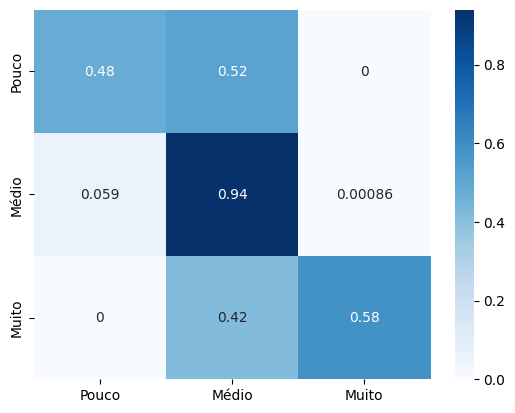

In [69]:
sns.heatmap(confusion_matrix(y_3_test, y3_pred, normalize='true'), xticklabels=['Pouco', 'Médio', 'Muito'], yticklabels=['Pouco', 'Médio', 'Muito'], annot=True, cmap='Blues');

É possível observar, especialmente a partir da matriz de confusão, que o modelo não apresentou casos de confusão entre classes extremas. Em outras palavras, não houve instâncias de alta ansiedade classificadas como baixa ansiedade, nem o inverso. As confusões concentram-se predominantemente nos níveis intermediários: 52% dos casos de baixa ansiedade foram classificados como ansiedade moderada, enquanto 42% dos casos de alta ansiedade foram classificados como ansiedade moderada. Esses resultados indicam uma separação mais difícil (e possivelmente subjetiva, conforme discutido na seção anterior) entre níveis adjacentes de ansiedade.

### PCA

In [70]:
pca = PCA(n_components=3)
X_3_train_2d = pca.fit_transform(X_3_train)
clf3.fit(X_3_train_2d, y_3_train)
print(f"Melhor valor de n_neighbors: {clf3.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 7


In [71]:
X_3_test_2d = pca.transform(X_3_test)
y3_pred_2d = clf3.predict(X_3_test_2d)
print(classification_report(y_3_test, y3_pred_2d))

              precision    recall  f1-score   support

         0.0       0.64      0.56      0.60       706
         1.0       0.73      0.81      0.77      1160
         2.0       0.95      0.76      0.84       161

    accuracy                           0.72      2027
   macro avg       0.77      0.71      0.74      2027
weighted avg       0.72      0.72      0.71      2027



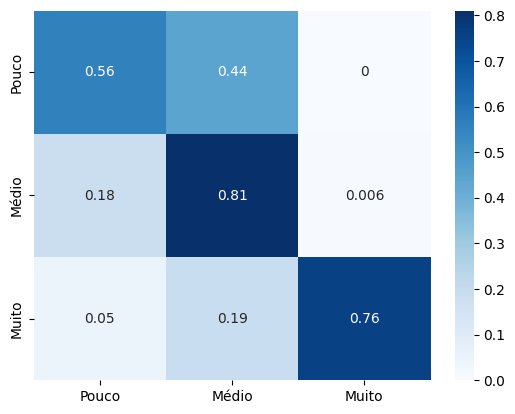

In [72]:
sns.heatmap(confusion_matrix(y_3_test, y3_pred_2d, normalize='true'), xticklabels=['Pouco', 'Médio', 'Muito'], yticklabels=['Pouco', 'Médio', 'Muito'],  annot=True, cmap='Blues');

A redução de dimensionalidade não acarretou perdas significativas de desempenho. O principal efeito observado foi a perda parcial de informações discriminativas entre o nível de baixa ansiedade e os níveis médio e alto. Como consequência, alguns casos originalmente classificados como ansiedade média passaram a ser rotulados como baixa ansiedade, assim como uma parcela dos casos de alta ansiedade, embora esse efeito não tenha sido significativo. Além disso, para casos de alta ansiedade, a redução resultou em uma diminuição de aproximadamente 4% na precisão, ao mesmo tempo em que a revocação aumentou em quase 20%. Esse resultado indica que a redução de dimensionalidade contribuiu para a mitigação de um viés prejudicial ao modelo.

### Testando com a remoção de features irrelevantes

In [73]:
X_3_train_no_irrelevant = train_df_level_3.drop(columns=irrelevant_cols + ['label', 'original_label'])
clf3.fit(X_3_train_no_irrelevant, y_3_train)
print(f"Melhor valor de n_neighbors: {clf3.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 21


In [74]:
y3_pred_no_irrelevant = clf3.predict(test_df_level_3.drop(columns=irrelevant_cols + ['label', 'original_label']))
print(classification_report(y_3_test, y3_pred_no_irrelevant))

              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78       706
         1.0       0.86      0.87      0.87      1160
         2.0       0.95      1.00      0.97       161

    accuracy                           0.85      2027
   macro avg       0.87      0.88      0.87      2027
weighted avg       0.85      0.85      0.85      2027



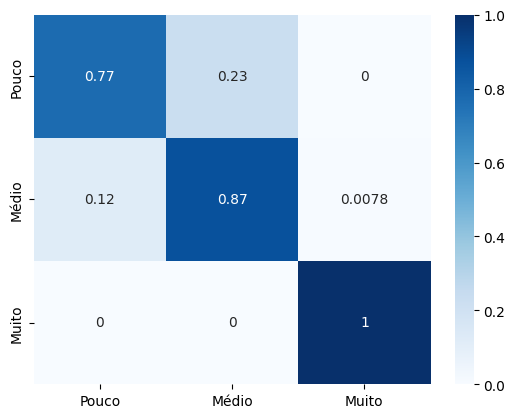

In [75]:
sns.heatmap(confusion_matrix(y_3_test, y3_pred_no_irrelevant, normalize='true'), xticklabels=['Pouco', 'Médio', 'Muito'], yticklabels=['Pouco', 'Médio', 'Muito'],  annot=True, cmap='Blues');

É interessante notar que, ao excluir as features de baixa relevância, houve uma melhora significativa em muitos pontos:

1. Aumento da revocão em 29% para casos de baixa ansiedade (ao custo de uma pequena diminuição na precisão: de 83% para 80%).
2. Aumento de 14% na precisão dos casos de moderada ansiedade (ao custo de uma queda de 7% na revocação).
3. Aumento da revocão para 100% (aumento de +40%) para casos de alta ansiedade (ao custo de uma pequena diminuição na precisão: de 99% para 95%).

Em resumo, remover tais features fez com que muitos casos de alta e baixa ansiedade antes classificados (incorretamente) como ansiedade moderada fossem corretamente classificados. Contudo, alguns casos de ansiedade moderada (possivelmente casos de pontuações adjacentes) acabaram "entrando" nos demais grupos.

## Nível 4

Nessa seção será avaliado o desempenho do KNN usando as categorias originais (níveis 1–10).

In [76]:
train_df_level_4 = pd.read_csv('train_data/train_level_4.csv')
X_4_train = train_df_level_4.drop('label', axis=1)
y_4_train = train_df_level_4['label']
test_df_level_4 = pd.read_csv('test_data/test_level_4.csv')
X_4_test = test_df_level_4.drop('label', axis=1)
y_4_test = test_df_level_4['label']

In [77]:
clf4 = GridSearchCV(KNeighborsClassifier(), params, cv=5)
clf4.fit(X_4_train, y_4_train)
print(f"Melhor valor de n_neighbors: {clf4.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 41


In [78]:
y4_pred = clf4.predict(X_4_test)
print(classification_report(y_4_test, y4_pred, zero_division=0))

              precision    recall  f1-score   support

         1.0       0.36      0.08      0.13       250
         2.0       0.33      0.22      0.26       450
         3.0       0.25      0.42      0.31       589
         4.0       0.25      0.42      0.31       584
         5.0       0.25      0.13      0.17       420
         6.0       0.00      0.00      0.00       155
         7.0       0.00      0.00      0.00        31
         8.0       0.32      0.28      0.30        95
         9.0       0.22      0.11      0.15        98
        10.0       0.33      0.19      0.24        78

    accuracy                           0.26      2750
   macro avg       0.23      0.19      0.19      2750
weighted avg       0.26      0.26      0.24      2750



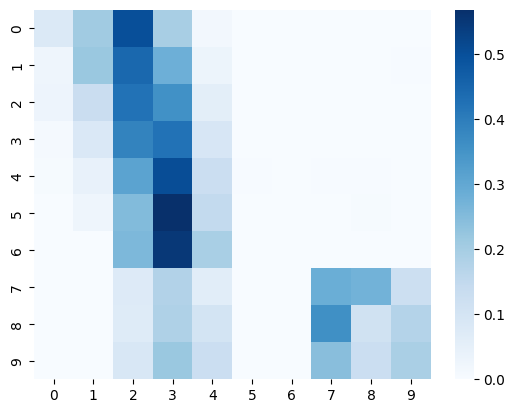

In [79]:
sns.heatmap(confusion_matrix(y_4_test, y4_pred, normalize='true'), cmap='Blues');

### PCA

In [80]:
pca = PCA(n_components=3)
X_4_train_2d = pca.fit_transform(X_4_train)
clf4.fit(X_4_train_2d, y_4_train)
print(f"Melhor valor de n_neighbors: {clf4.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 41


In [81]:
X_4_test_2d = pca.transform(X_4_test)
y4_pred_2d = clf4.predict(X_4_test_2d)
print(classification_report(y_4_test, y4_pred_2d, zero_division=0))

              precision    recall  f1-score   support

         1.0       0.22      0.05      0.08       250
         2.0       0.28      0.21      0.24       450
         3.0       0.23      0.39      0.29       589
         4.0       0.25      0.41      0.31       584
         5.0       0.28      0.16      0.20       420
         6.0       0.00      0.00      0.00       155
         7.0       0.00      0.00      0.00        31
         8.0       0.36      0.26      0.30        95
         9.0       0.30      0.14      0.19        98
        10.0       0.22      0.09      0.13        78

    accuracy                           0.25      2750
   macro avg       0.21      0.17      0.17      2750
weighted avg       0.24      0.25      0.23      2750



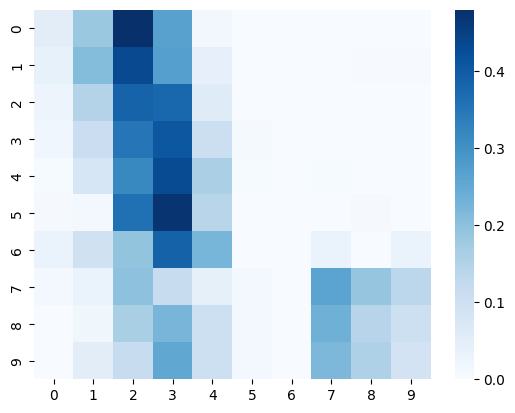

In [82]:
sns.heatmap(confusion_matrix(y_4_test, y4_pred_2d, normalize='true'), cmap='Blues');

### Testando com a remoção de features irrelevantes

In [83]:
X_4_train_no_irrelevant = train_df_level_4.drop(columns=irrelevant_cols + ['label'])
clf4.fit(X_4_train_no_irrelevant, y_4_train)
print(f"Melhor valor de n_neighbors: {clf4.best_params_['n_neighbors']}")

Melhor valor de n_neighbors: 41


              precision    recall  f1-score   support

         1.0       0.40      0.20      0.27       250
         2.0       0.35      0.32      0.33       450
         3.0       0.30      0.40      0.34       589
         4.0       0.33      0.46      0.38       584
         5.0       0.35      0.27      0.30       420
         6.0       0.42      0.03      0.06       155
         7.0       0.00      0.00      0.00        31
         8.0       0.29      0.38      0.33        95
         9.0       0.33      0.23      0.28        98
        10.0       0.28      0.31      0.29        78

    accuracy                           0.33      2750
   macro avg       0.31      0.26      0.26      2750
weighted avg       0.34      0.33      0.31      2750



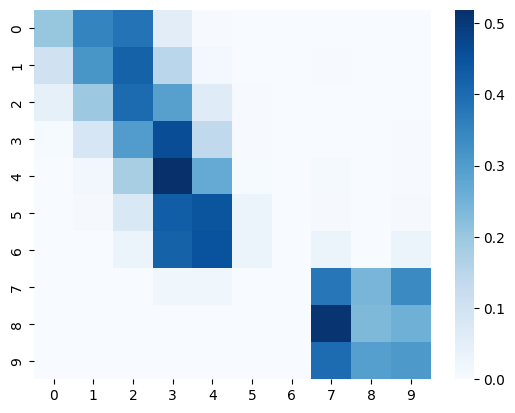

In [84]:
y4_pred_no_irrelevant = clf4.predict(test_df_level_4.drop(columns=irrelevant_cols + ['label']))
print(classification_report(y_4_test, y4_pred_no_irrelevant, zero_division=0))
sns.heatmap(confusion_matrix(y_4_test, y4_pred_no_irrelevant, normalize='true'), cmap='Blues');

Os resultados observados mostram que, ao analisar as medidas de desempenho para cada feature, o modelo não performou bem. Contudo, pode-se destacar alguns resultados interessantes:
1. Assim como aconteceu em seções anteriores, diminuir a dimensionalidade e remover features de baixa relevância aumentaram a média das medidas de desempenho (reforçando a hipótese da existência de features "prejudiciais").
   - Uma possível hipótese para essa sensibilidade é o fato de o modelo se basear puramente em distâncias.
2. A maior parte dos erros de predição ocorreu em classes adjacentes. Em outras palavras, para uma instância $x$ com rótulo $y$, as predições incorretas concentraram-se predominantemente no intervalo $[y-2,y+2]$, o que reforça o caráter subjetivo do problema.
3. O modelo apresentou dificuldade significativa em identificar instâncias associadas à ansiedade moderada (classes 5 e 6). Possivelmente, por se tratarem de valores de transição, suas features são facilmente confundidas. 

# Random Forest (RF)

In [85]:
from sklearn.ensemble import RandomForestClassifier

## TL;DR

**Principais análises**:
1. No geral o RF teve um desempenho significativamente superior aos observados usando KNN. Destaca-se o desempenho para os dados de nível 3 (ansiedade pequena, média e alta), onde o modelo conseguiu distinguir níveis moderados de forma bastante satisfatória.
2. Diferentemente do observado no KNN, a remoção de features de baixa relevância não resultou em melhorias significativas no desempenho do modelo.
   - Uma possível explicação é que o RF não se baseia em métricas de distância, mas sim na redução progressiva da impureza (como entropia ou índice de Gini) por meio da seleção das melhores features em cada divisão. Isso o torna naturalmente mais robusto à presença de features ruidosas ou pouco informativas.

## Nível 1

Análise do desempenho do Random Forest para classificar os grupos extremos de ansiedade (muito ansioso vs pouco ansioso).

In [86]:
train_df_level_1 = pd.read_csv('train_data/train_level_1.csv')
X_1_train = train_df_level_1.drop(['label', 'original_label'], axis=1)
Y_1_train = train_df_level_1['label']

test_df_level_1 = pd.read_csv('test_data/test_level_1.csv')
X_1_test = test_df_level_1.drop(['label', 'original_label'], axis=1)
Y_1_test = test_df_level_1['label']

In [88]:
params = {
    'n_estimators': [30, 50, 100, 200],
    'max_depth': [5, 10, 15, 20],
    'max_features': ['sqrt', 'log2', 1.0],
    'max_samples': [0.2, 0.6, 1.0]
}

In [89]:
clf = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5)
clf.fit(X_1_train, Y_1_train)
print(f"Melhores parâmetros: {clf.best_params_}")

Melhores parâmetros: {'max_depth': 5, 'max_features': 'sqrt', 'max_samples': 0.2, 'n_estimators': 30}


In [90]:
Y_pred = clf.predict(X_1_test)
print(classification_report(Y_1_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       701
           1       1.00      1.00      1.00       161

    accuracy                           1.00       862
   macro avg       1.00      1.00      1.00       862
weighted avg       1.00      1.00      1.00       862



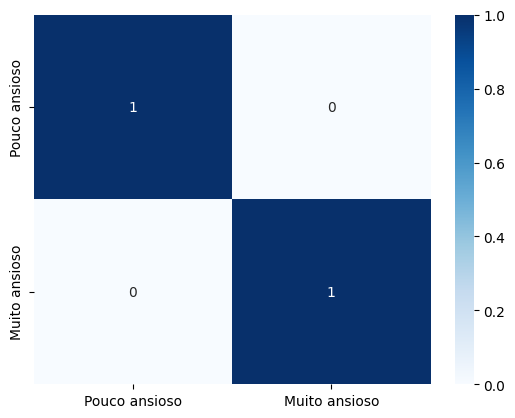

In [91]:
sns.heatmap(confusion_matrix(Y_1_test, Y_pred, normalize='true'), annot=True, cmap='Blues', xticklabels=['Pouco ansioso', 'Muito ansioso'], yticklabels=['Pouco ansioso', 'Muito ansioso']);

### PCA

A seguir, analisa-se o desempenho do Random Forest reduzindo a dimensionalidade dos dados de 31 para 3 componentes usando PCA.

In [92]:
pca = PCA(n_components=3)
X_1_train_3d = pca.fit_transform(X_1_train)
clf_pca = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5)
clf_pca.fit(X_1_train_3d, Y_1_train)
print(f"Melhores parâmetros (PCA): {clf_pca.best_params_}")

Melhores parâmetros (PCA): {'max_depth': 20, 'max_features': 'sqrt', 'max_samples': 1.0, 'n_estimators': 200}


In [93]:
X_1_test_3d = pca.transform(X_1_test)
Y_pred_3d = clf_pca.predict(X_1_test_3d)
print(classification_report(Y_1_test, Y_pred_3d))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       701
           1       0.96      0.89      0.92       161

    accuracy                           0.97       862
   macro avg       0.97      0.94      0.95       862
weighted avg       0.97      0.97      0.97       862



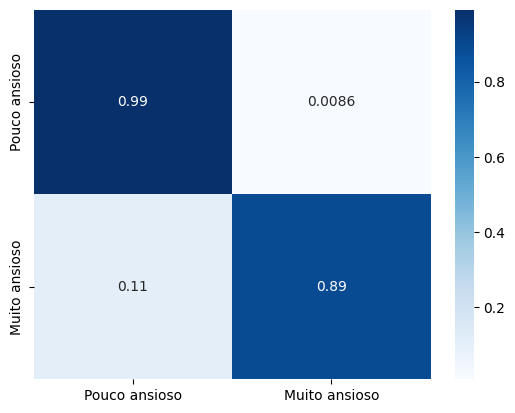

In [95]:
sns.heatmap(confusion_matrix(Y_1_test, Y_pred_3d, normalize='true'), annot=True, cmap='Blues', xticklabels=['Pouco ansioso', 'Muito ansioso'], yticklabels=['Pouco ansioso', 'Muito ansioso']);

### Testando com a remoção de features irrelevantes

In [96]:
aux = [ # Mesmas colunas consideradas irrelevantes para o KNN
    'Dizziness',
    'Recent Major Life Event',
    'Smoking',
    'Medication',
    'Occupation',
    'Gender'
]

irrelevant_cols = list()
for df_col in train_df_level_1.columns:
    for c in aux:
        if c in df_col:
            irrelevant_cols.append(df_col)

print("Número de colunas antes:", X_1_train.shape[1])
print("Número de colunas após a remoção:", X_1_train.shape[1] - len(irrelevant_cols))

Número de colunas antes: 30
Número de colunas após a remoção: 12


In [97]:
X_1_train_no_irrelevant = train_df_level_1.drop(columns=irrelevant_cols + ['label', 'original_label'])
clf_no_irrelevant = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5)
clf_no_irrelevant.fit(X_1_train_no_irrelevant, Y_1_train)
print(f"Melhores parâmetros (sem features irrelevantes): {clf_no_irrelevant.best_params_}")

Melhores parâmetros (sem features irrelevantes): {'max_depth': 5, 'max_features': 'sqrt', 'max_samples': 0.2, 'n_estimators': 100}


In [98]:
Y_pred_no_irrelevant = clf_no_irrelevant.predict(test_df_level_1.drop(columns=irrelevant_cols + ['label', 'original_label']))
print(classification_report(Y_1_test, Y_pred_no_irrelevant))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       701
           1       1.00      1.00      1.00       161

    accuracy                           1.00       862
   macro avg       1.00      1.00      1.00       862
weighted avg       1.00      1.00      1.00       862



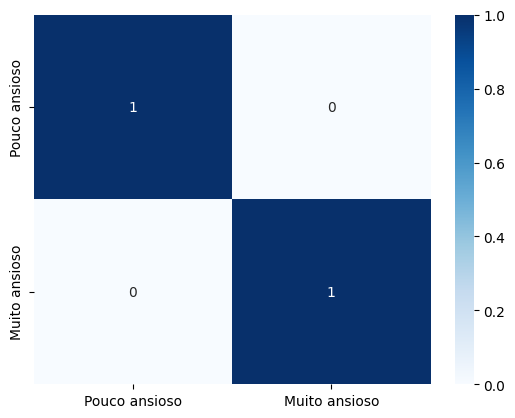

In [99]:
sns.heatmap(confusion_matrix(Y_1_test, Y_pred_no_irrelevant, normalize='true'), annot=True, cmap='Blues', xticklabels=['Pouco ansioso', 'Muito ansioso'], yticklabels=['Pouco ansioso', 'Muito ansioso']);

## Nível 2

Análise do desempenho do Random Forest para classificar o nível 2 (pouco/médio ansioso vs médio/muito ansioso).

In [100]:
train_df_level_2 = pd.read_csv('train_data/train_level_2.csv')
X_2_train = train_df_level_2.drop(['label', 'original_label'], axis=1)
Y_2_train = train_df_level_2['label']

test_df_level_2 = pd.read_csv('test_data/test_level_2.csv')
X_2_test = test_df_level_2.drop(['label', 'original_label'], axis=1)
Y_2_test = test_df_level_2['label']

In [101]:
clf = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5)
clf.fit(X_2_train, Y_2_train)
print(f"Melhores parâmetros: {clf.best_params_}")

Melhores parâmetros: {'max_depth': 20, 'max_features': 'log2', 'max_samples': 0.6, 'n_estimators': 100}


In [102]:
Y_pred = clf.predict(X_2_test)
print(classification_report(Y_2_test, Y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2293
           1       1.00      0.59      0.74       457

    accuracy                           0.93      2750
   macro avg       0.96      0.79      0.85      2750
weighted avg       0.94      0.93      0.92      2750



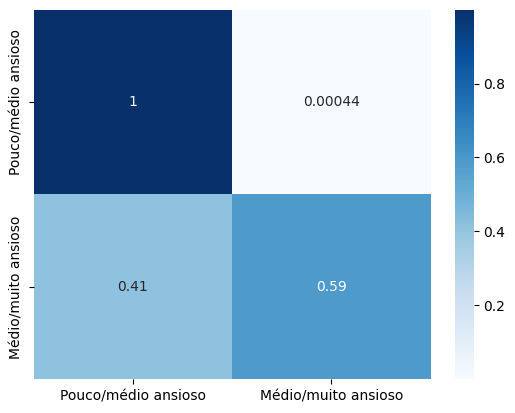

In [103]:
sns.heatmap(confusion_matrix(Y_2_test, Y_pred, normalize='true'), annot=True, cmap='Blues', xticklabels=['Pouco/médio ansioso', 'Médio/muito ansioso'], yticklabels=['Pouco/médio ansioso', 'Médio/muito ansioso']);

### PCA

In [104]:
pca = PCA(n_components=3)
X_2_train_3d = pca.fit_transform(X_2_train)
clf_pca = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5)
clf_pca.fit(X_2_train_3d, Y_2_train)
print(f"Melhores parâmetros (PCA): {clf_pca.best_params_}")

Melhores parâmetros (PCA): {'max_depth': 15, 'max_features': 1.0, 'max_samples': 0.6, 'n_estimators': 200}


In [105]:
X_2_test_3d = pca.transform(X_2_test)
Y_pred_3d = clf_pca.predict(X_2_test_3d)
print(classification_report(Y_2_test, Y_pred_3d))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2293
           1       0.90      0.56      0.69       457

    accuracy                           0.92      2750
   macro avg       0.91      0.77      0.82      2750
weighted avg       0.92      0.92      0.91      2750



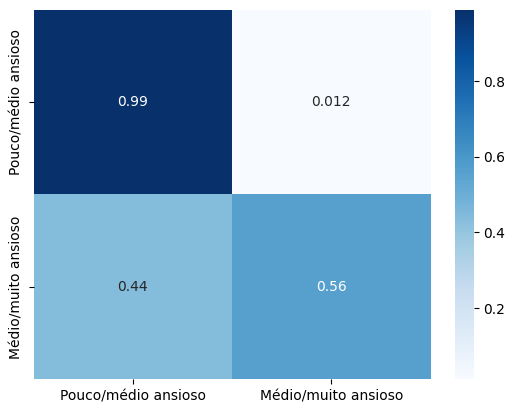

In [106]:
sns.heatmap(confusion_matrix(Y_2_test, Y_pred_3d, normalize='true'), annot=True, cmap='Blues', xticklabels=['Pouco/médio ansioso', 'Médio/muito ansioso'], yticklabels=['Pouco/médio ansioso', 'Médio/muito ansioso']);

### Testando com a remoção de features irrelevantes

In [107]:
aux = [
    'Dizziness',
    'Recent Major Life Event',
    'Smoking',
    'Medication',
    'Occupation',
    'Gender'
]

irrelevant_cols = list()
for df_col in train_df_level_1.columns:
    for c in aux:
        if c in df_col:
            irrelevant_cols.append(df_col)

print("Número de colunas antes:", X_2_train.shape[1])
print("Número de colunas após a remoção:", X_2_train.shape[1] - len(irrelevant_cols))

Número de colunas antes: 30
Número de colunas após a remoção: 12


In [108]:
X_2_train_no_irrelevant = train_df_level_2.drop(columns=irrelevant_cols + ['label', 'original_label'])
clf_no_irrelevant = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5)
clf_no_irrelevant.fit(X_2_train_no_irrelevant, Y_2_train)
print(f"Melhores parâmetros (sem features irrelevantes): {clf_no_irrelevant.best_params_}")

Melhores parâmetros (sem features irrelevantes): {'max_depth': 20, 'max_features': 'sqrt', 'max_samples': 1.0, 'n_estimators': 100}


In [109]:
Y_pred_no_irrelevant = clf_no_irrelevant.predict(test_df_level_2.drop(columns=irrelevant_cols + ['label', 'original_label']))
print(classification_report(Y_2_test, Y_pred_no_irrelevant))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2293
           1       0.96      0.60      0.74       457

    accuracy                           0.93      2750
   macro avg       0.95      0.80      0.85      2750
weighted avg       0.93      0.93      0.92      2750



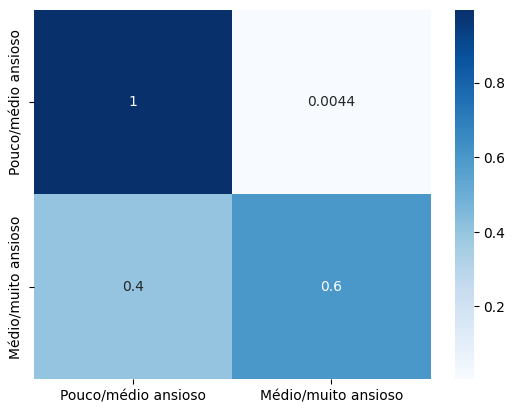

In [110]:
sns.heatmap(confusion_matrix(Y_2_test, Y_pred_no_irrelevant, normalize='true'), annot=True, cmap='Blues', xticklabels=['Pouco/médio ansioso', 'Médio/muito ansioso'], yticklabels=['Pouco/médio ansioso', 'Médio/muito ansioso']);

## Nível 3
Análise do Random Forest para o nível 3 (três classes: pouco, moderada, muito).

In [111]:
train_df_level_3 = pd.read_csv('train_data/train_level_3.csv')
X_3_train = train_df_level_3.drop(['label', 'original_label'], axis=1)
Y_3_train = train_df_level_3['label']

test_df_level_3 = pd.read_csv('test_data/test_level_3.csv')
X_3_test = test_df_level_3.drop(['label', 'original_label'], axis=1)
Y_3_test = test_df_level_3['label']

In [112]:
clf_rf3 = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5)
clf_rf3.fit(X_3_train, Y_3_train)
print(f"Melhores parâmetros: {clf_rf3.best_params_}")

Melhores parâmetros: {'max_depth': 20, 'max_features': 'sqrt', 'max_samples': 1.0, 'n_estimators': 200}


In [113]:
Y3_pred = clf_rf3.predict(X_3_test)
print(classification_report(Y_3_test, Y3_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.79      0.80       706
         1.0       0.87      0.89      0.88      1160
         2.0       1.00      0.99      0.99       161

    accuracy                           0.86      2027
   macro avg       0.90      0.89      0.89      2027
weighted avg       0.86      0.86      0.86      2027



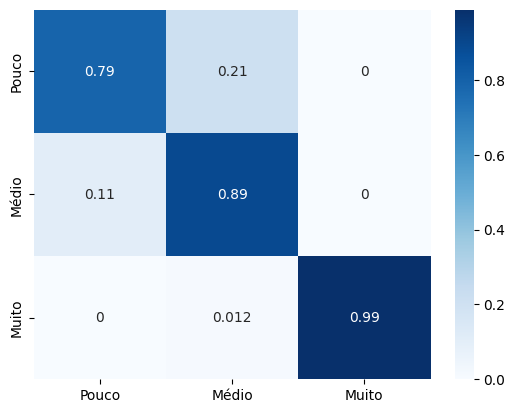

In [114]:
sns.heatmap(confusion_matrix(Y_3_test, Y3_pred, normalize='true'), xticklabels=['Pouco', 'Médio', 'Muito'], yticklabels=['Pouco', 'Médio', 'Muito'], annot=True, cmap='Blues');

### PCA
Redução para 3 componentes e reavaliação do Random Forest.

In [115]:
pca = PCA(n_components=3)
X_3_train_3d = pca.fit_transform(X_3_train)
clf_rf3_pca = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5)
clf_rf3_pca.fit(X_3_train_3d, Y_3_train)
print(f"Melhores parâmetros (PCA): {clf_rf3_pca.best_params_}")

Melhores parâmetros (PCA): {'max_depth': 15, 'max_features': 1.0, 'max_samples': 0.6, 'n_estimators': 100}


In [116]:
X_3_test_3d = pca.transform(X_3_test)
Y3_pred_3d = clf_rf3_pca.predict(X_3_test_3d)
print(classification_report(Y_3_test, Y3_pred_3d))

              precision    recall  f1-score   support

         0.0       0.63      0.52      0.57       706
         1.0       0.72      0.80      0.76      1160
         2.0       0.91      0.84      0.87       161

    accuracy                           0.71      2027
   macro avg       0.75      0.72      0.73      2027
weighted avg       0.70      0.71      0.70      2027



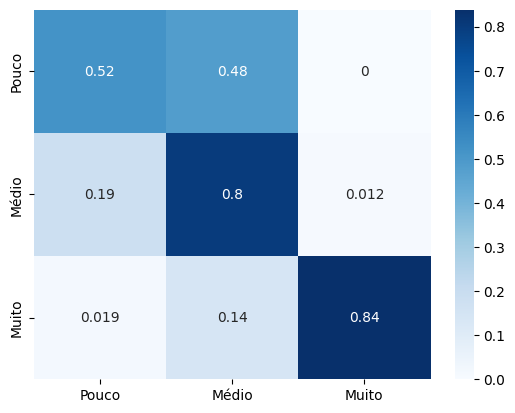

In [117]:
sns.heatmap(confusion_matrix(Y_3_test, Y3_pred_3d, normalize='true'), xticklabels=['Pouco', 'Médio', 'Muito'], yticklabels=['Pouco', 'Médio', 'Muito'], annot=True, cmap='Blues');

### Testando com a remoção de features irrelevantes
Remove as mesmas 6 features de baixa relevância e reavalia o modelo.

In [118]:
aux = [
    'Dizziness',
    'Recent Major Life Event',
    'Smoking',
    'Medication',
    'Occupation',
    'Gender'
]
irrelevant_cols = list()
for df_col in train_df_level_3.columns:
    for c in aux:
        if c in df_col:
            irrelevant_cols.append(df_col)
            
print("Número de colunas antes:", X_3_train.shape[1])
print("Número de colunas após a remoção:", X_3_train.shape[1] - len(irrelevant_cols))

Número de colunas antes: 30
Número de colunas após a remoção: 12


In [119]:
X_3_train_no_irrelevant = train_df_level_3.drop(columns=irrelevant_cols + ['label', 'original_label'])
clf_no_irrelevant = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5)
clf_no_irrelevant.fit(X_3_train_no_irrelevant, Y_3_train)
print(f"Melhores parâmetros (sem features irrelevantes): {clf_no_irrelevant.best_params_}")

Melhores parâmetros (sem features irrelevantes): {'max_depth': 15, 'max_features': 'sqrt', 'max_samples': 1.0, 'n_estimators': 200}


In [120]:
Y_pred_no_irrelevant = clf_no_irrelevant.predict(test_df_level_3.drop(columns=irrelevant_cols + ['label', 'original_label']))
print(classification_report(Y_3_test, Y_pred_no_irrelevant))

              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80       706
         1.0       0.87      0.88      0.88      1160
         2.0       1.00      0.99      0.99       161

    accuracy                           0.86      2027
   macro avg       0.89      0.89      0.89      2027
weighted avg       0.86      0.86      0.86      2027



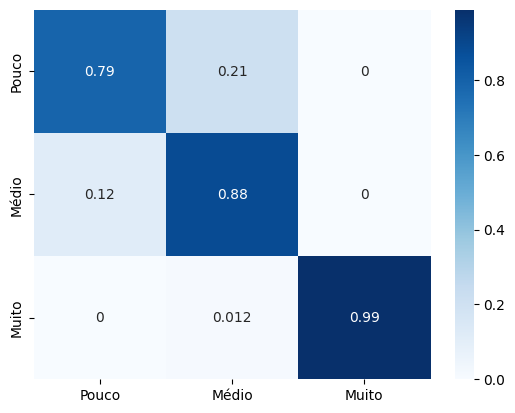

In [121]:
sns.heatmap(confusion_matrix(Y_3_test, Y_pred_no_irrelevant, normalize='true'), xticklabels=['Pouco', 'Médio', 'Muito'], yticklabels=['Pouco', 'Médio', 'Muito'], annot=True, cmap='Blues');

## Nível 4
Análise do Random Forest usando as categorias originais (níveis 1–10).

In [122]:
train_df_level_4 = pd.read_csv('train_data/train_level_4.csv')
X_4_train = train_df_level_4.drop('label', axis=1)
Y_4_train = train_df_level_4['label']

test_df_level_4 = pd.read_csv('test_data/test_level_4.csv')
X_4_test = test_df_level_4.drop('label', axis=1)
Y_4_test = test_df_level_4['label']

In [123]:
clf_rf4 = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5)
clf_rf4.fit(X_4_train, Y_4_train)
print(f"Melhores parâmetros: {clf_rf4.best_params_}")

Melhores parâmetros: {'max_depth': 5, 'max_features': 1.0, 'max_samples': 0.6, 'n_estimators': 200}


In [124]:
Y4_pred = clf_rf4.predict(X_4_test)
print(classification_report(Y_4_test, Y4_pred, zero_division=0))

              precision    recall  f1-score   support

         1.0       0.41      0.37      0.39       250
         2.0       0.36      0.31      0.33       450
         3.0       0.34      0.34      0.34       589
         4.0       0.32      0.47      0.38       584
         5.0       0.35      0.38      0.37       420
         6.0       0.11      0.01      0.01       155
         7.0       0.00      0.00      0.00        31
         8.0       0.33      0.77      0.46        95
         9.0       0.15      0.02      0.04        98
        10.0       0.09      0.01      0.02        78

    accuracy                           0.34      2750
   macro avg       0.25      0.27      0.23      2750
weighted avg       0.32      0.34      0.32      2750



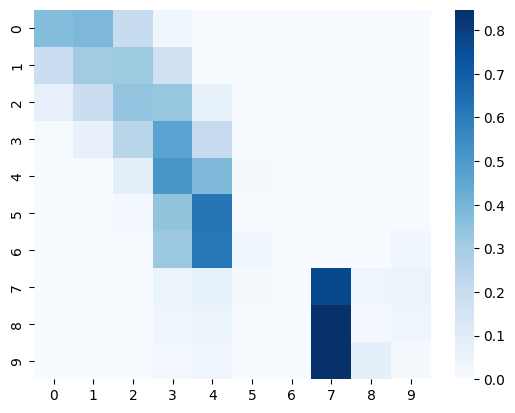

In [125]:
sns.heatmap(confusion_matrix(Y_4_test, Y4_pred, normalize='true'), cmap='Blues');

### PCA
Redução para 3 componentes e reavaliação do Random Forest.

In [126]:
pca = PCA(n_components=3)
X_4_train_3d = pca.fit_transform(X_4_train)
clf_rf4_pca = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5)
clf_rf4_pca.fit(X_4_train_3d, Y_4_train)
print(f"Melhores parâmetros (PCA): {clf_rf4_pca.best_params_}")

Melhores parâmetros (PCA): {'max_depth': 10, 'max_features': 1.0, 'max_samples': 0.6, 'n_estimators': 30}


In [127]:
X_4_test_3d = pca.transform(X_4_test)
Y4_pred_3d = clf_rf4_pca.predict(X_4_test_3d)
print(classification_report(Y_4_test, Y4_pred_3d, zero_division=0))

              precision    recall  f1-score   support

         1.0       0.21      0.06      0.09       250
         2.0       0.27      0.14      0.19       450
         3.0       0.24      0.42      0.30       589
         4.0       0.26      0.44      0.33       584
         5.0       0.25      0.12      0.16       420
         6.0       0.29      0.03      0.05       155
         7.0       0.00      0.00      0.00        31
         8.0       0.31      0.29      0.30        95
         9.0       0.25      0.13      0.17        98
        10.0       0.27      0.24      0.26        78

    accuracy                           0.25      2750
   macro avg       0.24      0.19      0.18      2750
weighted avg       0.25      0.25      0.22      2750



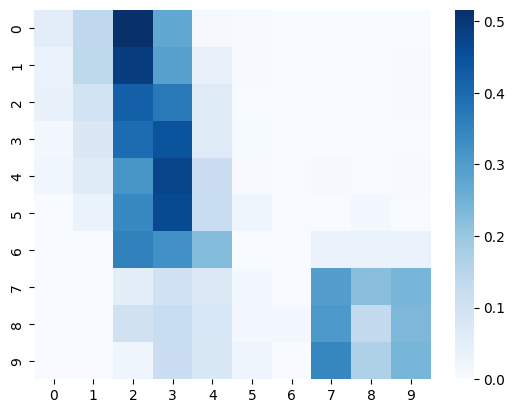

In [128]:
sns.heatmap(confusion_matrix(Y_4_test, Y4_pred_3d, normalize='true'), cmap='Blues');

### Testando com a remoção de features irrelevantes
Remove as mesmas 6 features de baixa relevância e reavalia o modelo.

In [129]:
aux = [
    'Dizziness',
    'Recent Major Life Event',
    'Smoking',
    'Medication',
    'Occupation',
    'Gender'
]
irrelevant_cols = list()
for df_col in train_df_level_4.columns:
    for c in aux:
        if c in df_col:
            irrelevant_cols.append(df_col)

print("Número de colunas antes:", X_4_train.shape[1])
print("Número de colunas após a remoção:", X_4_train.shape[1] - len(irrelevant_cols))

Número de colunas antes: 30
Número de colunas após a remoção: 12


In [130]:
X_4_train_no_irrelevant = train_df_level_4.drop(columns=irrelevant_cols + ['label'])
clf_rf4_no_irrelevant = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5)
clf_rf4_no_irrelevant.fit(X_4_train_no_irrelevant, Y_4_train)
print(f"Melhores parâmetros (sem features irrelevantes): {clf_rf4_no_irrelevant.best_params_}")

Melhores parâmetros (sem features irrelevantes): {'max_depth': 5, 'max_features': 1.0, 'max_samples': 0.6, 'n_estimators': 200}


In [131]:
Y4_pred_no_irrelevant = clf_rf4_no_irrelevant.predict(test_df_level_4.drop(columns=irrelevant_cols + ['label']))
print(classification_report(Y_4_test, Y4_pred_no_irrelevant, zero_division=0))

              precision    recall  f1-score   support

         1.0       0.43      0.39      0.41       250
         2.0       0.36      0.31      0.33       450
         3.0       0.34      0.33      0.33       589
         4.0       0.32      0.46      0.38       584
         5.0       0.34      0.38      0.36       420
         6.0       0.08      0.01      0.01       155
         7.0       0.00      0.00      0.00        31
         8.0       0.32      0.72      0.44        95
         9.0       0.15      0.02      0.04        98
        10.0       0.11      0.03      0.04        78

    accuracy                           0.34      2750
   macro avg       0.24      0.26      0.23      2750
weighted avg       0.31      0.34      0.32      2750



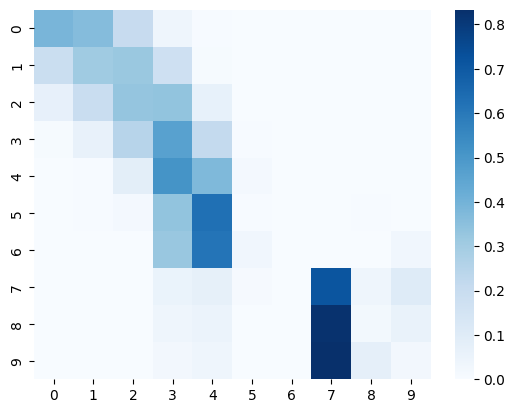

In [132]:
sns.heatmap(confusion_matrix(Y_4_test, Y4_pred_no_irrelevant, normalize='true'), cmap='Blues');